# Library

In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import datetime as dt
import numpy as np
import time
import seaborn as sns
import nltk
import collections
import multiprocessing as mp
import re
import os
import warnings
import random
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import statistics
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

# Get Twitter Data

### META

In [16]:
# Creating list to append tweet data to
tweetslist = []

# Using TwitterSearchScraper to scrape data cointaining the words 'Bitcoin' and 'Buy' and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('$META since:2022-07-30 until:2022-09-3').get_items()):
    if i>40000000000000:
        break
    tweetslist.append([tweet.date, tweet.id, tweet.content, tweet.user.username,tweet.user.followersCount])

In [17]:
META = pd.DataFrame(tweetslist, columns=['Datetime', 'Tweet Id', 'Text', 'Username','Followers'])
# Add two hours to time time zone into account
META['Datetime'] = META['Datetime'] + timedelta(hours=2)
META.to_csv('META.csv')

In [18]:
# Find only the tweets between 15.30 and 22.00 opening hours for the stock market
META['Datetime'] = pd.to_datetime(META['Datetime'])
META = META.set_index('Datetime')
META_open = META.between_time('15:30', '22:00')
META_open = META_open.reset_index()
         
# Save to csv format
META_open.to_csv('META_open.csv', index=False)

### TSLA

In [164]:
# Creating list to append tweet data to
tweetslist = []

# Using TwitterSearchScraper to scrape data cointaining the words 'Bitcoin' and 'Buy' and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('$TSLA since:2022-07-30 until:2022-09-3').get_items()):
    if i>40000000000000:
        break
    tweetslist.append([tweet.date, tweet.id, tweet.content, tweet.user.username,tweet.user.followersCount])

In [165]:
TSLA = pd.DataFrame(tweetslist, columns=['Datetime', 'Tweet Id', 'Text', 'Username','Followers'])
# Add two hours to time time zone into account
TSLA['Datetime'] = TSLA['Datetime'] + timedelta(hours=2)
TSLA.to_csv('TSLA.csv')

In [166]:
# Find only the tweets between 15.30 and 22.00 opening hours for the stock market
TSLA['Datetime'] = pd.to_datetime(TSLA['Datetime'])
TSLA = TSLA.set_index('Datetime')
TSLA_open = TSLA.between_time('15:30', '22:00')
TSLA_open = TSLA_open.reset_index()
         
# Save to csv format
TSLA_open.to_csv('TSLA_open.csv', index=False)

### NIO

In [170]:
# Creating list to append tweet data to
tweetslist = []

# Using TwitterSearchScraper to scrape data cointaining the words 'Bitcoin' and 'Buy' and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('$NIO since:2022-07-30 until:2022-09-3').get_items()):
    if i>40000000000000:
        break
    tweetslist.append([tweet.date, tweet.id, tweet.content, tweet.user.username,tweet.user.followersCount])

In [171]:
NIO = pd.DataFrame(tweetslist, columns=['Datetime', 'Tweet Id', 'Text', 'Username','Followers'])
# Add two hours to time time zone into account
NIO['Datetime'] = NIO['Datetime'] + timedelta(hours=2)
NIO.to_csv('NIO.csv')

In [172]:
# Find only the tweets between 15.30 and 22.00 opening hours for the stock market
NIO['Datetime'] = pd.to_datetime(NIO['Datetime'])
NIO = NIO.set_index('Datetime')
NIO_open = NIO.between_time('15:30', '22:00')
NIO_open = NIO_open.reset_index()
         
# Save to csv format
NIO_open.to_csv('NIO_open.csv', index=False)

### AMZN

In [179]:
# Creating list to append tweet data to
tweetslist = []

# Using TwitterSearchScraper to scrape data cointaining the words 'Bitcoin' and 'Buy' and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('$AMZN since:2022-07-30 until:2022-09-3').get_items()):
    if i>4000000000000:
        break
    tweetslist.append([tweet.date, tweet.id, tweet.content, tweet.user.username,tweet.user.followersCount])

In [180]:
AMZN = pd.DataFrame(tweetslist, columns=['Datetime', 'Tweet Id', 'Text', 'Username','Followers'])
# Add two hours to time time zone into account
AMZN['Datetime'] = AMZN['Datetime'] + timedelta(hours=2)
AMZN.to_csv('AMZN.csv')

In [181]:
# Find only the tweets between 15.30 and 22.00 opening hours for the stock market
AMZN['Datetime'] = pd.to_datetime(AMZN['Datetime'])
AMZN = AMZN.set_index('Datetime')
AMZN_open = AMZN.between_time('15:30', '22:00')
AMZN_open = AMZN_open.reset_index()
         
# Save to csv format
AMZN_open.to_csv('AMZN_open.csv', index=False)

# The Function

In [3]:
# down load the stopwords from different countries
nltk.download('stopwords')
from nltk.corpus import stopwords
# stops = set(stopwords.words('english')) # just for illustration of simple english
liste_of_countries = ['arabic','azerbaijani', 'danish','dutch','english', 'finnish', 'french', 'german', 'greek','hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']
stopwordlist = []
for i in liste_of_countries: 
    stopwordlist.append(set(stopwords.words(i)))
stopwordlist = [item for sublist in stopwordlist for item in sublist] # make list of list to a simpel list

# Defining dictionary containing all emojis with their meanings.
emojis = {'✅️': 'check', '⚡️': 'lightning', '📉': 'stockdown', '😕': 'notsatisfied', '🤯': 'brain', 
          '🙈': 'money', '🤡': 'clovn', '❤️': 'heart', '😁': 'bigsmile',
          '👏': 'clap', '🙌🏻': 'twohands','💀': 'dead', '🍿': 'popcorn', 
          '💯': 'onehundred', '😎': 'sunclasses', '🔑': 'key', '🐻': 'bear', '👀': 'eyes',
          '🤝': 'deal', '💰': 'sackmoney', '💵': 'money', '🍎': 'apple', '🤙': 'cool',
          '🚄': 'train', '😬': 'nerveous', "🥰": 'inlove', '👍': 'thumpup', 
          '😂': 'laught', '🇺🇦': 'ukraine','❌': 'rederror','🚀': 'rocket', '🔥': 'fire'}

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


In [51]:
# Function for prepossing
def prepos(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE) # remove the  https and www
    text = re.sub(r'\@w+|\#|\$','',text) # Remove the #, @ and $
    for emoji in emojis.keys():
            text = text.replace(emoji, "EMOJI" + emojis[emoji] + " ") # substitute all the emojies this specific text
    text = re.sub("[^a-zA-Z0-9]", " ", text) # Replace all non alphabets
    text = re.sub(r"(.)\1\1+", r"\1\1", text) # Replace 3 or more consecutive letters by 2 letter.
    text = re.sub(r'[0-9]+', '', text) # delete all digits
    text_tokens = word_tokenize(text) # divides the words into tokens
    filtered_text = [w for w in text_tokens if not w in stopwordlist] # filter though the stoplist
    stemmer = PorterStemmer() # defining the porterstemmer (ift. bøjninger)
    filtered_text = [stemmer.stem(word) for word in filtered_text] # apply the porterstemmer
    return " ".join(filtered_text)

# Sentiment classification function 
def sentiment(label):
    if label < -0.5:
        return "Very Negative"
    elif label < 0:
        return "Negative"
    elif label == 0:
        return "Neutral"
    elif label < 0.5:
        return "Positive" 
    elif label < 1.05:
        return "Very Positive" 

# Evaluate model
def model_result(x_training,y_training,x_validation,y_validation,validation_data):
        import warnings
        warnings.filterwarnings('ignore')
        # Code for the LinearSVC
        LinReg_model =  LinearSVC()
        LinReg_model.fit(x_training, y_training)
        LinReg_pred = LinReg_model.predict(x_validation)
        LinReg_accuracy = accuracy_score(LinReg_pred, y_validation)
        print("Test accuracy for LinReg: {:.2f}%".format(LinReg_accuracy*100)) #Print(test accuracy)
        # Print the confusion matrix
        style.use('classic')
        cm = confusion_matrix(y_validation, LinReg_pred, labels=LinReg_model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=LinReg_model.classes_)
        disp.plot()
        disp.ax_.set_title("LinearSVC")

        # Code for LogisticRegression
        LogReg_model = LogisticRegression()
        LogReg_model.fit(x_training, y_training)
        LogReg_pred = LogReg_model.predict(x_validation)
        LogReg_accuracy = accuracy_score(LogReg_pred, y_validation)
        print("Test accuracy for LogReg: {:.2f}%".format(LogReg_accuracy*100)) #Print(test accuracy)
        # Print the confusion matrix
        style.use('classic')
        cm = confusion_matrix(y_validation, LogReg_pred, labels=LogReg_model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=LogReg_model.classes_)
        disp.plot()
        disp.ax_.set_title("LogisticRegression")

        if LogReg_accuracy > LinReg_accuracy:
            print("Best model: LogisticRegression")
            validation_data['predictet_sentiment'] = LogReg_pred
            model = LogReg_model
            return model
        else:
            print("Best model: LinearSVC")
            validation_data['predictet_sentiment'] = LinReg_pred
            model = LinReg_model
            return model

# implement trading strategy for long
def trading_strategy(stock_path,df_path):
    # read in the relevant stock data
    df_stock = pd.read_excel(stock_path) # Read excel file
    df_stock = df_stock.sort_values(by=['Date']) # Sort the datetime from the beginning to the end
    df_stock = df_stock.reset_index(drop=True) # Make a new index:  
    df_stock = df_stock[df_stock['Date'].between('2022-08-22 15:30:00', '2022-08-26 22:00:00')] #Extract only the date of interest
    df_stock = df_stock.reset_index(drop=True) # Reset the index
    df_stock = df_stock.rename(columns={'Date': 'Datetime'}) # change the column name to 'Datetime'

    # Read in the relevant output data
    df_output = df_path # Read the file 
    df_output['Datetime'] = df_output['Datetime'].astype('datetime64') # convert to the right dateformat  
    df_output['Datetime'] = df_output['Datetime'].dt.ceil('min') # round all the tweets up!
    
    # Merge the two dataframes
    combined = pd.merge(df_stock, df_output, how="outer", on=["Datetime"])

    mylist = list(dict.fromkeys(combined["Datetime"]))
    monday = mylist[0:390]
    tuesday = mylist[390:390*2]
    wednesday = mylist[390*2:390*3]
    thursday = mylist[390*3:390*4]
    friday = mylist[390*4:390*5]
    
    weekdays = []
    
    # Create List of lists
    weekdays.append(monday)
    weekdays.append(tuesday)
    weekdays.append(wednesday)
    weekdays.append(thursday)
    weekdays.append(friday)
    
    lis = range(len(monday)-6)
    weeks =[0,1,2,3,4]
    followers = [500,2500,5000,10000] # number of followers 
    hold_position = [1,2,3,4,5] # number of minutes we hold on to the position (meaning we sell after one minute if hold_position is 1)
    best_strategy = []
    followers_count = []
    hold_position_count = []
    number_of_transactions =[]

    for u in followers:
        for y in hold_position:
            buy_price = []
            buy_time = []
            for e in weeks:
                for i in lis:
                    first = combined[combined["Datetime"]==weekdays[e][i]]
                    #second = combined[combined["Datetime"]==weekdays[e][i]] # take the first two minutes and combine all the data of relevance into one dataframe
                    frames = [first] #, second
                    result = pd.concat(frames)
                    result = result[result['predictet_sentiment'].notna()]
                    if result['Followers'].sum() > u: # if above 5000 then append
                        buy_price.append(first['Last Price'].reset_index(drop=True)[0])
                        buy_time.append(first['Datetime'].reset_index(drop=True)[0])
            store = []
            for i in range(len(buy_price)-1):
                buy_stock = combined[combined['Datetime']==buy_time[i]]['Last Price'].reset_index(drop=True)[0] # just for 
                sell_stock = combined[combined['Datetime']==(buy_time[i] + timedelta(minutes=y))]['Last Price'].reset_index(drop=True)[0] 
                difference = sell_stock - buy_stock
                store.append(difference)
            sum = np.sum(store)
            number_of_trans = len(store)

            best_strategy.append(sum)
            followers_count.append(u)
            hold_position_count.append(y)
            number_of_transactions.append(number_of_trans)
    
    strategy_df = pd.DataFrame(
        {'Return': best_strategy,
         'Followers': followers_count,
         'Minutes in holdposition': hold_position_count,
         'Number of Transactions':number_of_transactions
        })
    print(strategy_df)
    best_strategy = strategy_df.iloc[strategy_df['Return'].idxmax()]
    best_return = best_strategy[0]
    best_follwers = best_strategy[1]
    best_holdtime = best_strategy[2]

    return best_return, best_follwers, best_holdtime, strategy_df, best_strategy

# implement trading strategy for long
def trading_strategy_short(stock_path,df_path):
    # read in the relevant stock data
    df_stock = pd.read_excel(stock_path) # Read excel file
    df_stock = df_stock.sort_values(by=['Date']) # Sort the datetime from the beginning to the end
    df_stock = df_stock.reset_index(drop=True) # Make a new index:  
    df_stock = df_stock[df_stock['Date'].between('2022-08-22 15:30:00', '2022-08-26 22:00:00')] #Extract only the date of interest
    df_stock = df_stock.reset_index(drop=True) # Reset the index
    df_stock = df_stock.rename(columns={'Date': 'Datetime'}) # change the column name to 'Datetime'

    # Read in the relevant output data
    df_output = df_path # Read the file 
    df_output['Datetime'] = df_output['Datetime'].astype('datetime64') # convert to the right dateformat  
    df_output['Datetime'] = df_output['Datetime'].dt.ceil('min') # round all the tweets up!
    
    # Merge the two dataframes
    combined = pd.merge(df_stock, df_output, how="outer", on=["Datetime"])

    mylist = list(dict.fromkeys(combined["Datetime"]))
    monday = mylist[0:390]
    tuesday = mylist[390:390*2]
    wednesday = mylist[390*2:390*3]
    thursday = mylist[390*3:390*4]
    friday = mylist[390*4:390*5]
    
    weekdays = []
    
    # Create List of lists
    weekdays.append(monday)
    weekdays.append(tuesday)
    weekdays.append(wednesday)
    weekdays.append(thursday)
    weekdays.append(friday)
    
    lis = range(len(monday)-6)
    weeks =[0,1,2,3,4]
    followers = [500,2500,5000,10000] # number of followers 
    hold_position = [1,2,3,4,5] # number of minutes we hold on to the position (meaning we sell after one minute if hold_position is 1)
    best_strategy = []
    followers_count = []
    hold_position_count = []
    number_of_transactions =[]

    for u in followers:
        for y in hold_position:
            buy_price = []
            buy_time = []
            for e in weeks:
                for i in lis:
                    first = combined[combined["Datetime"]==weekdays[e][i]]
                    #second = combined[combined["Datetime"]==weekdays[e][i]] # take the first two minutes and combine all the data of relevance into one dataframe
                    frames = [first] #, second
                    result = pd.concat(frames)
                    result = result[result['predictet_sentiment'].notna()]
                    if result['Followers'].sum() > u: # if above 5000 then append
                        buy_price.append(first['Last Price'].reset_index(drop=True)[0])
                        buy_time.append(first['Datetime'].reset_index(drop=True)[0])
            store = []
            for i in range(len(buy_price)-1):
                buy_stock = combined[combined['Datetime']==buy_time[i]]['Last Price'].reset_index(drop=True)[0] # just for 
                sell_stock = combined[combined['Datetime']==(buy_time[i] + timedelta(minutes=y))]['Last Price'].reset_index(drop=True)[0] 
                difference = buy_stock - sell_stock
                store.append(difference)
            sum = np.sum(store)
            number_of_trans = len(store)

            best_strategy.append(sum)
            followers_count.append(u)
            hold_position_count.append(y)
            number_of_transactions.append(number_of_trans)
    
    strategy_df = pd.DataFrame(
        {'Return': best_strategy,
         'Followers': followers_count,
         'Minutes in holdposition': hold_position_count,
         'Number of Transactions':number_of_transactions
        })
    print(strategy_df)
    best_strategy = strategy_df.iloc[strategy_df['Return'].idxmax()]
    best_return = best_strategy[0]
    best_follwers = best_strategy[1]
    best_holdtime = best_strategy[2]

    return best_return, best_follwers, best_holdtime, strategy_df, best_strategy

# Trading strategy for testset
def trading_strategy_test(stock_path,df_path,countoffollowers, timeinthemarket):
    # read in the relevant stock data
    df_stock = pd.read_excel(stock_path) # Read excel file
    df_stock = df_stock.sort_values(by=['Date']) # Sort the datetime from the beginning to the end
    df_stock = df_stock.reset_index(drop=True) # Make a new index:  
    df_stock = df_stock[df_stock['Date'].between('2022-08-29 15:30:00', '2022-09-02 22:00:00')] #Extract only the date of interest
    df_stock = df_stock.reset_index(drop=True) # Reset the index
    df_stock = df_stock.rename(columns={'Date': 'Datetime'}) # change the column name to 'Datetime'

    # Read in the relevant output data
    df_output = df_path # Read the file 
    df_output['Datetime'] = df_output['Datetime'].astype('datetime64') # convert to the right dateformat  
    df_output['Datetime'] = df_output['Datetime'].dt.ceil('min') # round all the tweets up!
    
    # Merge the two dataframes
    combined = pd.merge(df_stock, df_output, how="outer", on=["Datetime"])

    mylist = list(dict.fromkeys(combined["Datetime"]))
    monday = mylist[0:390]
    tuesday = mylist[390:390*2]
    wednesday = mylist[390*2:390*3]
    thursday = mylist[390*3:390*4]
    friday = mylist[390*4:390*5]
    
    weekdays = []
    
    # Create List of lists
    weekdays.append(monday)
    weekdays.append(tuesday)
    weekdays.append(wednesday)
    weekdays.append(thursday)
    weekdays.append(friday)

    lis = range(len(monday)-6)
    weeks =[0,1,2,3,4]
    followers = [countoffollowers] # number of followers 
    hold_position = [timeinthemarket] # number of minutes we hold on to the position (meaning we sell after one minute if hold_position is 1)
    best_strategy = []
    followers_count = []
    hold_position_count = []
    number_of_transactions =[]

    for u in followers:
        for y in hold_position:
            buy_price = []
            buy_time = []
            for e in weeks:
                for i in lis:
                    first = combined[combined["Datetime"]==weekdays[e][i]]
                    #second = combined[combined["Datetime"]==weekdays[e][i]] # take the first two minutes and combine all the data of relevance into one dataframe
                    frames = [first] #, second
                    result = pd.concat(frames)
                    result = result[result['predictet_sentiment'].notna()]
                    if result['Followers'].sum() > u: # if above 5000 then append
                        buy_price.append(first['Last Price'].reset_index(drop=True)[0])
                        buy_time.append(first['Datetime'].reset_index(drop=True)[0])
            store = []
            for i in range(len(buy_price)-1):
                buy_stock = combined[combined['Datetime']==buy_time[i]]['Last Price'].reset_index(drop=True)[0] # just for 
                sell_stock = combined[combined['Datetime']==(buy_time[i] + timedelta(minutes=y))]['Last Price'].reset_index(drop=True)[0] 
                difference = sell_stock - buy_stock
                store.append(difference)
            sum = np.sum(store)
            number_of_trans = len(store)

            best_strategy.append(sum)
            followers_count.append(u)
            hold_position_count.append(y)
            number_of_transactions.append(number_of_trans)
    
    strategy_df = pd.DataFrame(
        {'Return': best_strategy,
         'Followers': followers_count,
         'Minutes in holdposition': hold_position_count,
         'Number of Transactions':number_of_transactions
        })
    print(strategy_df)
    best_strategy = strategy_df.iloc[strategy_df['Return'].idxmax()]
    best_test_return = best_strategy[0]
    best_follwers = best_strategy[1]
    best_holdtime = best_strategy[2]

    return best_test_return
 
# Trading strategy for testset
def trading_strategy_test_short(stock_path,df_path,countoffollowers, timeinthemarket):
    # read in the relevant stock data
    df_stock = pd.read_excel(stock_path) # Read excel file
    df_stock = df_stock.sort_values(by=['Date']) # Sort the datetime from the beginning to the end
    df_stock = df_stock.reset_index(drop=True) # Make a new index:  
    df_stock = df_stock[df_stock['Date'].between('2022-08-29 15:30:00', '2022-09-02 22:00:00')] #Extract only the date of interest
    df_stock = df_stock.reset_index(drop=True) # Reset the index
    df_stock = df_stock.rename(columns={'Date': 'Datetime'}) # change the column name to 'Datetime'

    # Read in the relevant output data
    df_output = df_path # Read the file 
    df_output['Datetime'] = df_output['Datetime'].astype('datetime64') # convert to the right dateformat  
    df_output['Datetime'] = df_output['Datetime'].dt.ceil('min') # round all the tweets up!
    
    # Merge the two dataframes
    combined = pd.merge(df_stock, df_output, how="outer", on=["Datetime"])

    mylist = list(dict.fromkeys(combined["Datetime"]))
    monday = mylist[0:390]
    tuesday = mylist[390:390*2]
    wednesday = mylist[390*2:390*3]
    thursday = mylist[390*3:390*4]
    friday = mylist[390*4:390*5]
    
    weekdays = []
    
    # Create List of lists
    weekdays.append(monday)
    weekdays.append(tuesday)
    weekdays.append(wednesday)
    weekdays.append(thursday)
    weekdays.append(friday)

    lis = range(len(monday)-6)
    weeks =[0,1,2,3,4]
    followers = [countoffollowers] # number of followers 
    hold_position = [timeinthemarket] # number of minutes we hold on to the position (meaning we sell after one minute if hold_position is 1)
    best_strategy = []
    followers_count = []
    hold_position_count = []
    number_of_transactions =[]

    for u in followers:
        for y in hold_position:
            buy_price = []
            buy_time = []
            for e in weeks:
                for i in lis:
                    first = combined[combined["Datetime"]==weekdays[e][i]]
                    #second = combined[combined["Datetime"]==weekdays[e][i]] # take the first two minutes and combine all the data of relevance into one dataframe
                    frames = [first] #, second
                    result = pd.concat(frames)
                    result = result[result['predictet_sentiment'].notna()]
                    if result['Followers'].sum() > u: # if above 5000 then append
                        buy_price.append(first['Last Price'].reset_index(drop=True)[0])
                        buy_time.append(first['Datetime'].reset_index(drop=True)[0])
            store = []
            for i in range(len(buy_price)-1):
                buy_stock = combined[combined['Datetime']==buy_time[i]]['Last Price'].reset_index(drop=True)[0] # just for 
                sell_stock = combined[combined['Datetime']==(buy_time[i] + timedelta(minutes=y))]['Last Price'].reset_index(drop=True)[0] 
                difference = buy_stock - sell_stock
                store.append(difference)
            sum = np.sum(store)
            number_of_trans = len(store)

            best_strategy.append(sum)
            followers_count.append(u)
            hold_position_count.append(y)
            number_of_transactions.append(number_of_trans)
    
    strategy_df = pd.DataFrame(
        {'Return': best_strategy,
         'Followers': followers_count,
         'Minutes in holdposition': hold_position_count,
         'Number of Transactions':number_of_transactions
        })
    print(strategy_df)
    best_strategy = strategy_df.iloc[strategy_df['Return'].idxmax()]
    best_test_return = best_strategy[0]
    best_follwers = best_strategy[1]
    best_holdtime = best_strategy[2]

    return best_test_return

# The main Function for the sentiment analysis
def function(path_directory, stock_ticker, path_price):
    open = pd.read_csv(path_directory) # open the csv file 
    analyzer = SentimentIntensityAnalyzer() # Import the sentiment VADER analyzer
    open['compound'] = open['Text'].astype(str).apply(lambda Text: analyzer.polarity_scores(Text)['compound']) # Make a new column with the compound
    open = open.loc[open['Datetime'].str.len() == 25]# We observe some strange datetime format and try to solve this problem by deleting all rows that do not have a datetime format
    open = open.sort_values(by=['Datetime']) # Sort the datetime from the beginning to the end
    open = open.reset_index(drop=True) # Make a new index   
    print(open.isnull().sum()) 
    open = open.dropna(how='any',axis=0) 
    print(open.isnull().sum()) 
    open = open.reset_index(drop=True) 
    open['prepos'] = open['Text'].apply(prepos) # Apply the prepos function to the text column 
    open = open.drop_duplicates('prepos') # Drop duplicates in the new prepossed column
    open = open.reset_index(drop=True) #Reset index
    open['VADER_sentiment'] = open['compound'].apply(sentiment) # Making a new column with the classification based on vader
    # making the training dataset
    training_1 = open[open['Datetime'].between('2022-08-01 15:29:00', '2022-08-05 22:01:00')]
    training_2 = open[open['Datetime'].between('2022-08-08 15:29:00', '2022-08-12 22:01:00')]
    training_3 = open[open['Datetime'].between('2022-08-15 15:29:00', '2022-08-19 22:01:00')]
    training = pd.concat([training_1, training_2, training_3])
    # making the validation dataset 
    validation = open[open['Datetime'].between('2022-08-22 15:29:00', '2022-08-26 22:01:00')]
    # making the test dataset
    test = open[open['Datetime'].between('2022-08-29 15:29:00', '2022-09-02 22:01:00')]
    #combining the datasets into a new open set
    open = pd.concat([training, validation, test])
    open = open.reset_index(drop=True)

    # Make the most frequent word picture for very positive tweets
    pos_tweets = open[open.VADER_sentiment == 'Very Positive']
    pos_tweets = pos_tweets.sort_values(['compound'], ascending= False)
    text = ' '.join([word for word in pos_tweets['prepos']])
    plt.figure(figsize=(20,15), facecolor='None')
    twitter_picture = np.array(Image.open('/Users/Jens/Desktop/Seminar/Pictures/CS_close.png'))
    wordcloud = WordCloud(max_words=1000, width=1600, height=800,mask = twitter_picture).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('Most frequent words in positive tweets', fontsize=19)
    print(plt.show())
    
    # Make the most frequent word picture for very negative tweets
    neg_tweets = open[open.VADER_sentiment == 'Very Negative']
    neg_tweets = neg_tweets.sort_values(['compound'], ascending= False)
    text = ' '.join([word for word in neg_tweets['prepos']])
    plt.figure(figsize=(20,15), facecolor='None')
    twitter_picture = np.array(Image.open('/Users/Jens/Desktop/Seminar/Pictures/CS_close.png'))
    wordcloud = WordCloud(max_words=1000, width=1600, height=800,mask = twitter_picture).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('Most frequent words in negative tweets', fontsize=19)
    print(plt.show())  

    # Machine learning part
    vect = CountVectorizer(ngram_range=(1,2)).fit(open['prepos']) # apply the countvecotrizer function
    feature_names = vect.get_feature_names()
    print("Features: {}\n".format(len(feature_names)))

    X = open['prepos'] # Define the X variable as the preposcessed words from the tweets
    Y = open['VADER_sentiment'] # Define the Y variable as the VADER_sentiment (one of the 5 classifiers)
    X = vect.transform(X) # Transform the X varible with the countvectorizer function from before

    # Make a train and test dataset by setting 20% of the dataset to the training dataset
    val_size = len(test+validation)
    test_size = len(test)
    training_size = len(training)

    x_train = X[:-val_size] 
    x_val = X[training_size:-test_size] 
    x_test = X[-test_size:] # this testset contains only 5 days of open market data
    y_train = Y[:-val_size]
    y_val = Y[training_size:-test_size] 
    y_test = Y[-test_size:] # this testset contains only 5 days of open market data
    
    # Run the model function to compare the linear and logistic regression:
    model = model_result(x_train,y_train,x_val,y_val,validation)

    #test['predictet_sentiment'] = logreg_pred # make a new column with the predictet sentiment
    
    fig_1 = plt.figure(figsize=(10,3))
    sns.countplot(x='VADER_sentiment', data = validation) # Plot the sentiment of the VADER analysis
    fig_2 = plt.figure(figsize=(10,3))
    sns.countplot(x='predictet_sentiment', data = validation) # Plot my "homemade" sentiment anlysis distibution
    
    # The Buy predicted
    buy_predicted = validation[validation.predictet_sentiment == 'Very Positive'] # Extract only the very positive labels
    buy_predicted['Datetime'] = buy_predicted['Datetime'].astype('datetime64') # Convert to the right dateformat
    buy_predicted['Datetime'] = buy_predicted['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S') # Remove the UTC timezone
    buy_predicted['Datetime'] = buy_predicted['Datetime'].astype('datetime64') # Convert to datetime64
    buy_predicted.to_csv(f'/Users/Jens/Desktop/Seminar/output/{stock_ticker}/{stock_ticker}_buy_predicted.csv', index=False)

    # The sell predicted
    sell_predicted = validation[validation.predictet_sentiment == 'Very Negative'] # Extract only the very negative labels
    sell_predicted['Datetime'] = sell_predicted['Datetime'].astype('datetime64') # Convert to the right dateformat
    sell_predicted['Datetime'] = sell_predicted['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S') # Remove the UTC timezone
    sell_predicted['Datetime'] = sell_predicted['Datetime'].astype('datetime64') # Convert to datetime64
    sell_predicted.to_csv(f'/Users/Jens/Desktop/Seminar/output/{stock_ticker}/{stock_ticker}_sell_predicted.csv', index=False)

    # The buy VADER
    buy_VADER = validation[validation.VADER_sentiment == 'Very Positive'] # Extract only the very positive labels
    buy_VADER['Datetime'] = buy_VADER['Datetime'].astype('datetime64') # Convert to the right dateformat
    buy_VADER['Datetime'] = buy_VADER['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S') # Remove the UTC timezone
    buy_VADER['Datetime'] = buy_VADER['Datetime'].astype('datetime64') # Convert to datetime64
    buy_VADER.to_csv(f'/Users/Jens/Desktop/Seminar/output/{stock_ticker}/{stock_ticker}_buy_VADER.csv', index=False)
    
    # The sell VADER
    sell_VADER = validation[validation.VADER_sentiment == 'Very Negative'] # Extract only the very positive labels
    sell_VADER['Datetime'] = sell_VADER['Datetime'].astype('datetime64') # Convert to the right dateformat
    sell_VADER['Datetime'] = sell_VADER['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S') # Remove the UTC timezone
    sell_VADER['Datetime'] = sell_VADER['Datetime'].astype('datetime64') # Convert to datetime64
    sell_VADER.to_csv(f'/Users/Jens/Desktop/Seminar/output/{stock_ticker}/{stock_ticker}_sell_VADER.csv', index=False)

    #trading_strategy(path_price,buy_predicted)

    returns_pred_long, followers_pred_long, holdtime_pred_long, df_pred_long, best_pred_long = trading_strategy(path_price,buy_predicted) # for the prediction long side
    returns_pred_short, followers_pred_short, holdtime_pred_short, df_pred_short, best_pred_short = trading_strategy_short(path_price,sell_predicted) # for the prediction short side
    returns_VADER_long, followers_VADER_long, holdtime_VADER_long, df_VADER_long, best_VADER_long = trading_strategy(path_price,buy_VADER) # for the VADER long side
    returns_VADER_short, followers_VADER_short, holdtime_VADER_short, df_VADER_short, best_VADER_short = trading_strategy_short(path_price,sell_VADER) # for the VADER long side
    
    best_pred_long["Data"] = "pred_long"
    best_pred_short["Data"] = "pred_short"
    best_VADER_long["Data"] = "VADER_long"
    best_VADER_short["Data"] = "VADER_short"

    best_parameters = pd.concat([best_pred_long, best_pred_short,best_VADER_long,best_VADER_short], axis=0)
    print(best_parameters)
    #model = model_result(x_train,y_train,x_val,y_val,validation)

    #df_pred_long.to_csv(f'/Users/Jens/Desktop/Seminar/seaborn/df_pred_long.csv', index=False)
    #df_pred_short.to_csv(f'/Users/Jens/Desktop/Seminar/seaborn/df_pred_short.csv', index=False)
    #df_VADER_long.to_csv(f'/Users/Jens/Desktop/Seminar/seaborn/df_VADER_long.csv', index=False)
    #df_VADER_short.to_csv(f'/Users/Jens/Desktop/Seminar/seaborn/df_VADER_short.csv', index=False)
    #
    #df_1 = pd.read_csv('/Users/Jens/Desktop/Seminar/seaborn/df_pred_long.csv')
    #df_2 = pd.read_csv('/Users/Jens/Desktop/Seminar/seaborn/df_pred_short.csv')
    #df_3 = pd.read_csv('/Users/Jens/Desktop/Seminar/seaborn/df_VADER_long.csv')
    #df_4 = pd.read_csv('/Users/Jens/Desktop/Seminar/seaborn/df_VADER_short.csv')


    #df_pred_short["Return"] = -df_pred_short["Return"] # since we go short we the negative of the long position  
    #df_VADER_short["Return"] = -df_VADER_short["Return"] # since we go short we the negative of the long position

    palette = sns.color_palette("bright", 6)
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16,12))
    fig.suptitle(f'{stock_ticker}', fontsize=30)
    sns.lineplot(
        data=df_pred_long, x="Minutes in holdposition", y="Return",
        hue="Followers",
        legend="full",palette=palette, ax=axes[0,0]).set_title('Prediction Long')
    sns.lineplot(
        data=df_pred_short, x="Minutes in holdposition", y="Return",
        hue="Followers",
        legend="full",palette=palette, ax=axes[1,0]).set_title('Prediction Short')
    sns.lineplot(
        data=df_VADER_long, x="Minutes in holdposition", y="Return",
        hue="Followers",
        legend="full",palette=palette, ax=axes[0,1]).set_title('VADER Long')
    sns.lineplot(
        data=df_VADER_short, x="Minutes in holdposition", y="Return",
        hue="Followers",
        legend="full",palette=palette, ax=axes[1,1]).set_title('VADER Short')
    plt.show()


    model_pred = model.predict(x_test)
    test['predictet_sentiment'] = model_pred
    accuracy = accuracy_score(model_pred, y_test)
    print("Test accuracy for test_model: {:.2f}%".format(accuracy*100))

    # The buypredicted
    buy_predicted_test = test[test.predictet_sentiment == 'Very Positive'] # Extract only the very positive labels
    buy_predicted_test['Datetime'] = buy_predicted_test['Datetime'].astype('datetime64') # Convert to the right dateformat
    buy_predicted_test['Datetime'] = buy_predicted_test['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S') # Remove the UTC timezone
    buy_predicted_test['Datetime'] = buy_predicted_test['Datetime'].astype('datetime64') # Convert to datetime64

    # The sell predicted
    sell_predicted_test = test[test.predictet_sentiment == 'Very Negative'] # Extract only the very negative labels
    sell_predicted_test['Datetime'] = sell_predicted_test['Datetime'].astype('datetime64') # Convert to the right dateformat
    sell_predicted_test['Datetime'] = sell_predicted_test['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S') # Remove the UTC timezone
    sell_predicted_test['Datetime'] = sell_predicted_test['Datetime'].astype('datetime64') # Convert to datetime64

    # The buy VADER
    buy_VADER_test = test[test.VADER_sentiment == 'Very Positive'] # Extract only the very positive labels
    buy_VADER_test['Datetime'] = buy_VADER_test['Datetime'].astype('datetime64') # Convert to the right dateformat
    buy_VADER_test['Datetime'] = buy_VADER_test['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S') # Remove the UTC timezone
    buy_VADER_test['Datetime'] = buy_VADER_test['Datetime'].astype('datetime64') # Convert to datetime64
    
    # The sell VADER
    sell_VADER_test = test[test.VADER_sentiment == 'Very Negative'] # Extract only the very positive labels
    sell_VADER_test['Datetime'] = sell_VADER_test['Datetime'].astype('datetime64') # Convert to the right dateformat
    sell_VADER_test['Datetime'] = sell_VADER_test['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S') # Remove the UTC timezone
    sell_VADER_test['Datetime'] = sell_VADER_test['Datetime'].astype('datetime64') # Convert to datetime64

    best_pred_long = trading_strategy_test(path_price,buy_predicted_test,followers_pred_long, holdtime_pred_long)
    best_pred_short = trading_strategy_test_short(path_price,sell_predicted_test,followers_pred_short, holdtime_pred_short)
    best_VADER_long = trading_strategy_test(path_price,buy_VADER_test,followers_VADER_long, holdtime_VADER_long)
    best_VADER_short = trading_strategy_test_short(path_price,sell_VADER_test,followers_VADER_short, holdtime_VADER_short) 
    print("Best pred return for long: {:.2f}".format(best_pred_long))
    print("Best pred return for short: {:.2f}".format(best_pred_short)) # remember to take the negative since short
    print("Best VADER return for long: {:.2f}".format(best_VADER_long))
    print("Best VADER return for short: {:.2f}".format(best_VADER_short)) 
    
    total_pred = np.sum([best_pred_long, best_pred_short])
    total_vader = np.sum([best_VADER_long,best_VADER_short])
    print(("TOTAL for pred: {:.4f}".format(total_pred)))
    print(("TOTAL for Vader: {:.4f}".format(total_vader)))
    return total_pred, best_parameters

## RUN FUNCTION

### META

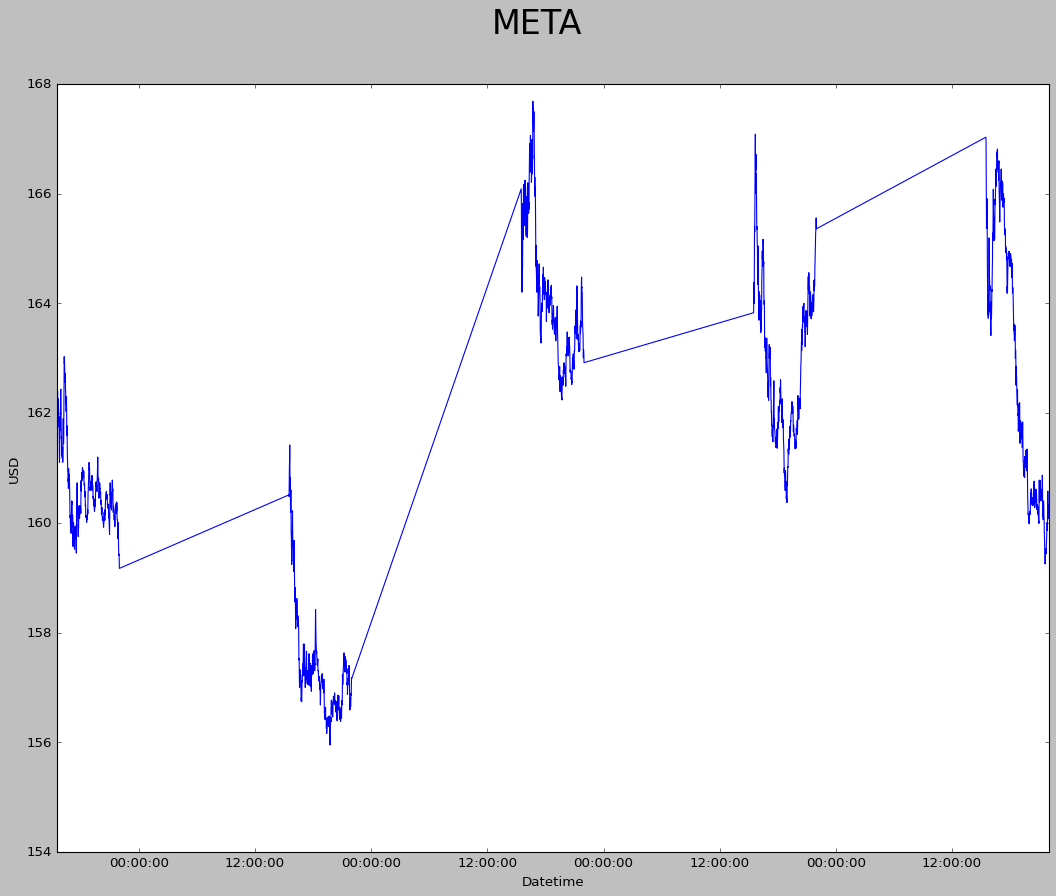

In [65]:
# read in the relevant stock data
palette = sns.color_palette("bright", 6)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,12))
fig.suptitle('META', fontsize=30)
df_stock = pd.read_excel('/Users/Jens/Desktop/Seminar/STOCK_DATA/META.xlsx') # Read excel file
df_stock = df_stock.sort_values(by=['Date']) # Sort the datetime from the beginning to the end
df_stock = df_stock.reset_index(drop=True) # Make a new index:  
df_stock = df_stock[df_stock['Date'].between('2022-08-29 15:30:00', '2022-09-02 22:00:00')] #Extract only the date of interest
df_stock = df_stock.reset_index(drop=True) # Reset the index
df_stock = df_stock.rename(columns={'Date': 'Datetime'}) # change the column name to 'Datetime'
df = pd.DataFrame(df_stock,columns=['Datetime','Last Price'])
sns.lineplot( data=df, x="Datetime", y="Last Price",
        legend="full",palette=palette)
plt.ylabel('USD')
plt.show()        

Datetime      0
Tweet Id      0
Text          0
Username     25
Followers    25
compound      0
dtype: int64
Datetime     0
Tweet Id     0
Text         0
Username     0
Followers    0
compound     0
dtype: int64


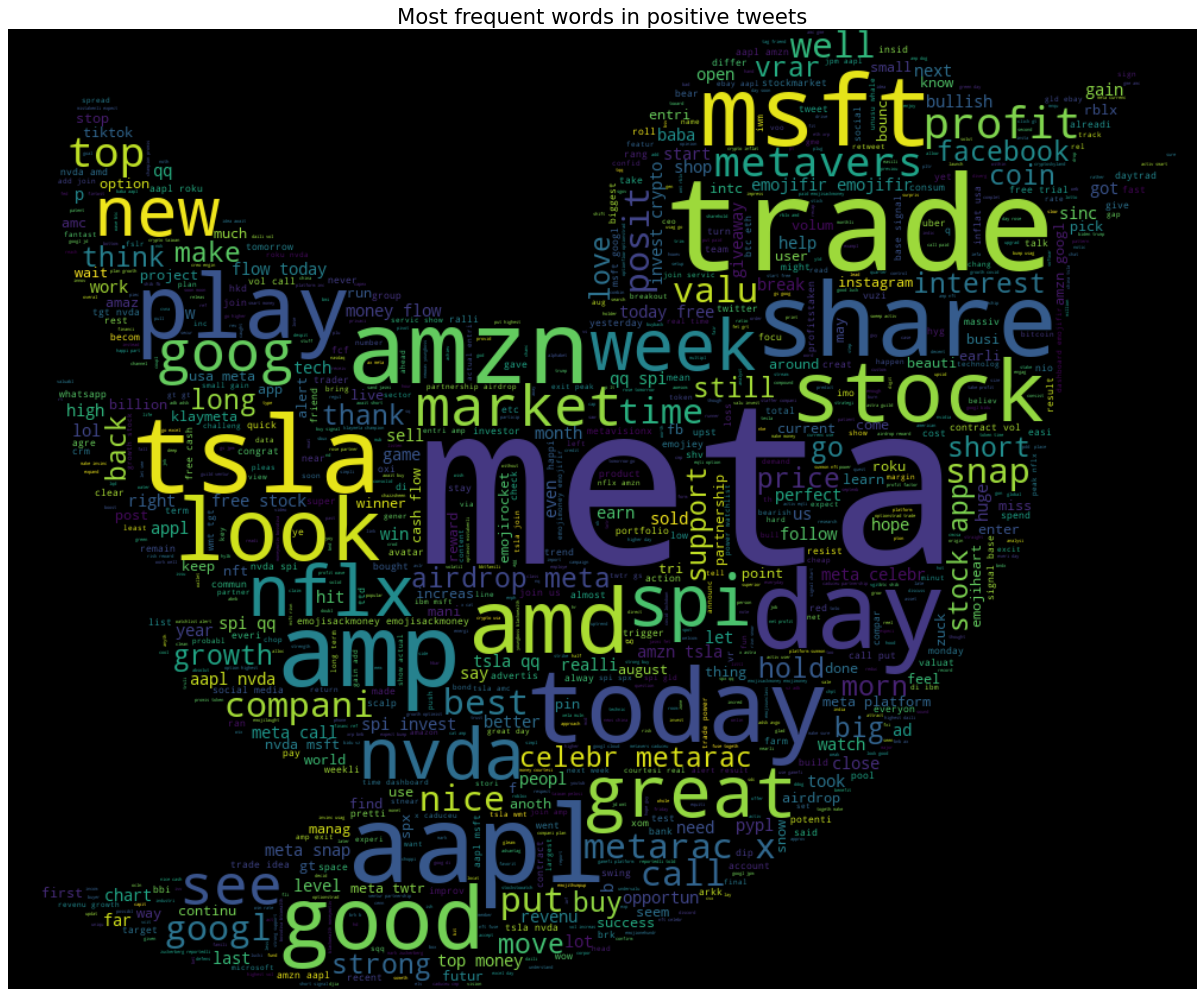

None


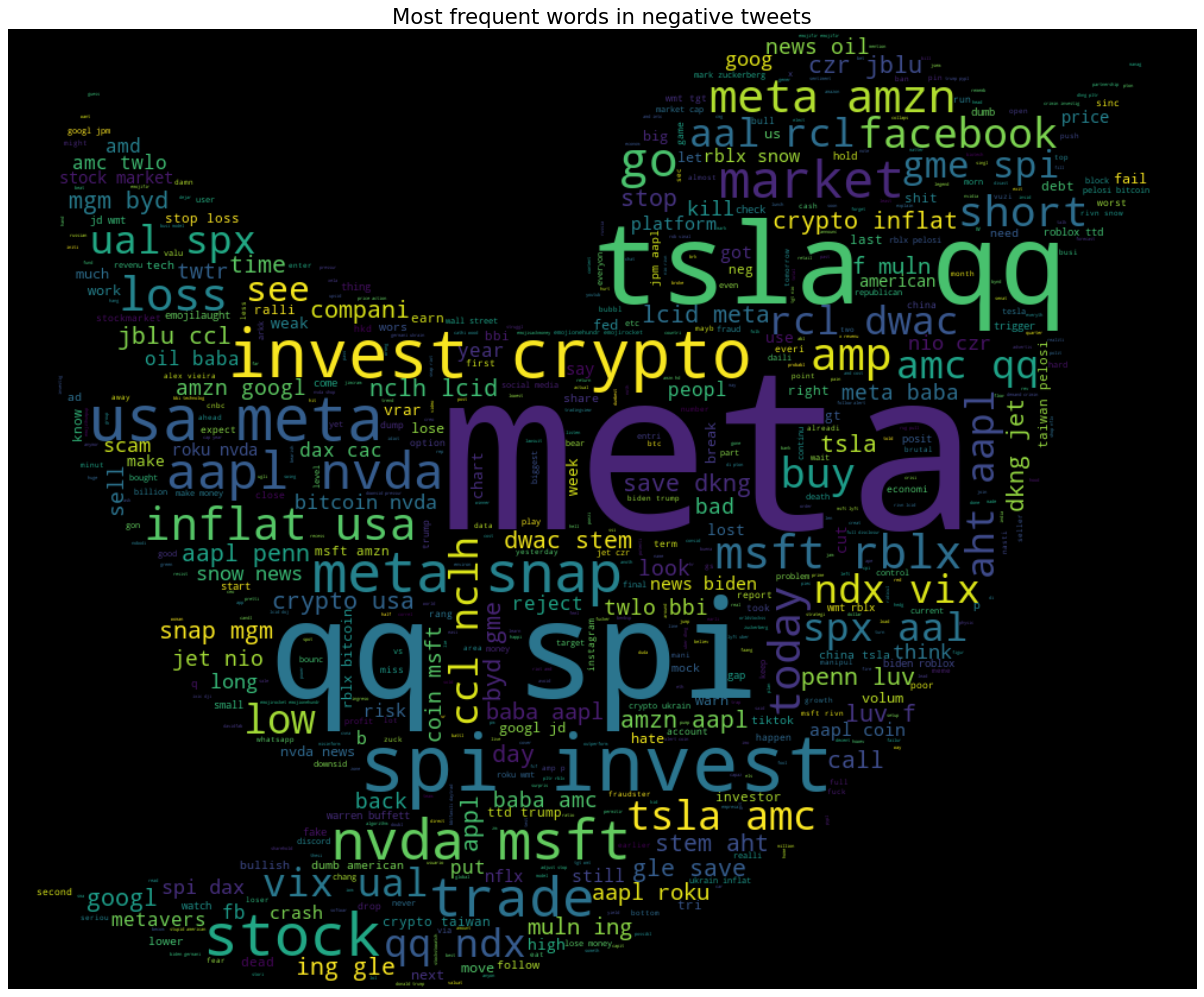

None
Features: 66620

Test accuracy for LinReg: 63.99%
Test accuracy for LogReg: 62.73%
Best model: LinearSVC
    Return  Followers  Minutes in holdposition  Number of Transactions
0   0.3063        500                        1                      78
1  -0.4380        500                        2                      78
2  -1.5109        500                        3                      78
3  -3.7658        500                        4                      78
4  -4.2558        500                        5                      78
5   0.4361       2500                        1                      51
6   1.0191       2500                        2                      51
7  -0.5831       2500                        3                      51
8  -1.4202       2500                        4                      51
9  -2.5784       2500                        5                      51
10  0.4675       5000                        1                      41
11  2.0775       5000                 

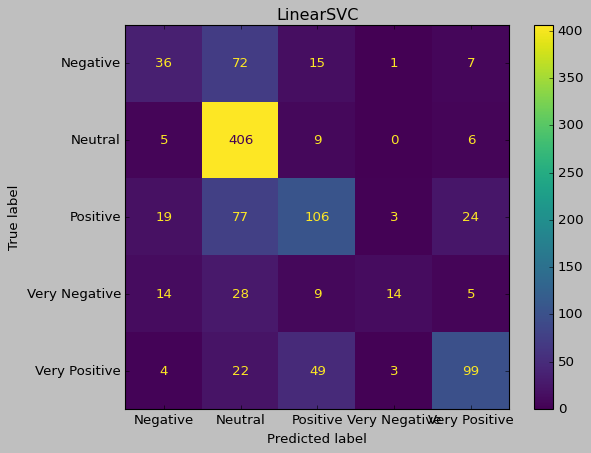

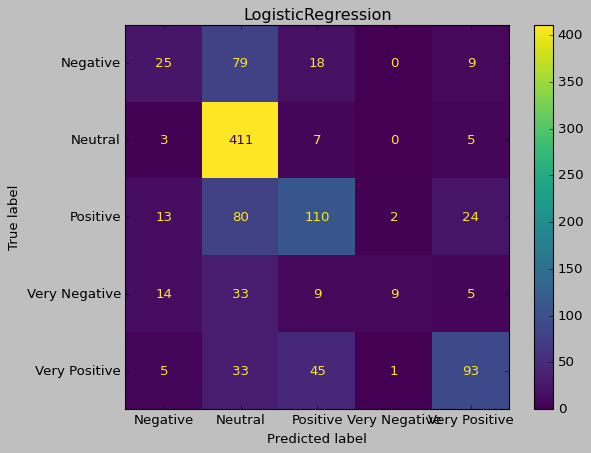

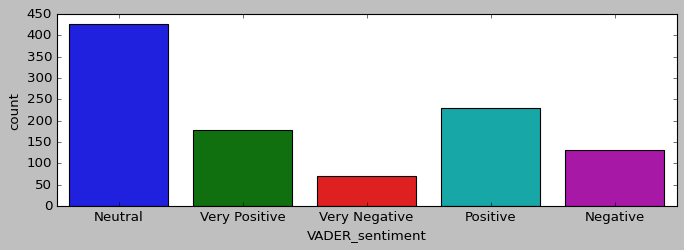

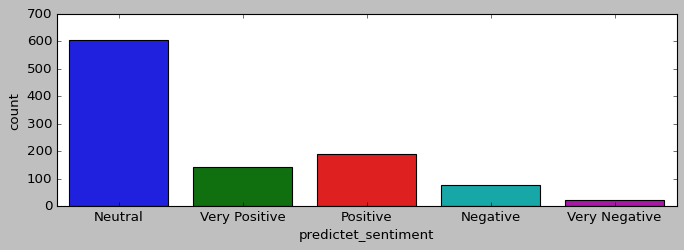

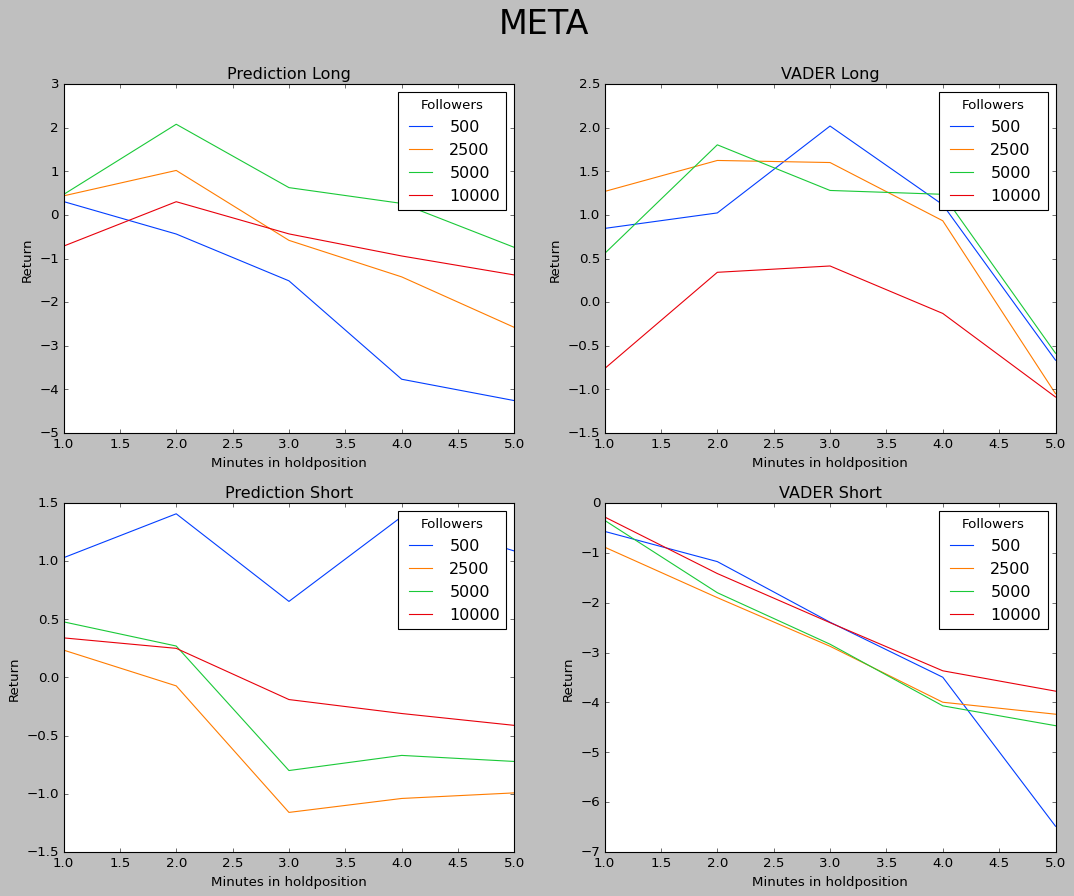

Test accuracy for test_model: 66.21%
   Return  Followers  Minutes in holdposition  Number of Transactions
0  0.5133     5000.0                      2.0                      38
   Return  Followers  Minutes in holdposition  Number of Transactions
0 -1.8981      500.0                      2.0                      14
   Return  Followers  Minutes in holdposition  Number of Transactions
0 -3.5495      500.0                      3.0                     121
   Return  Followers  Minutes in holdposition  Number of Transactions
0  0.6489    10000.0                      1.0                      12
Best pred return for long: 0.51
Best pred return for short: -1.90
Best VADER return for long: -3.55
Best VADER return for short: 0.65
TOTAL for pred: -1.38
TOTAL for Vader: -2.90


In [46]:
total_META, best_parameters_META = function('/Users/Jens/Desktop/Seminar/META_open.csv','META','/Users/Jens/Desktop/Seminar/STOCK_DATA/META.xlsx')

### TSLA

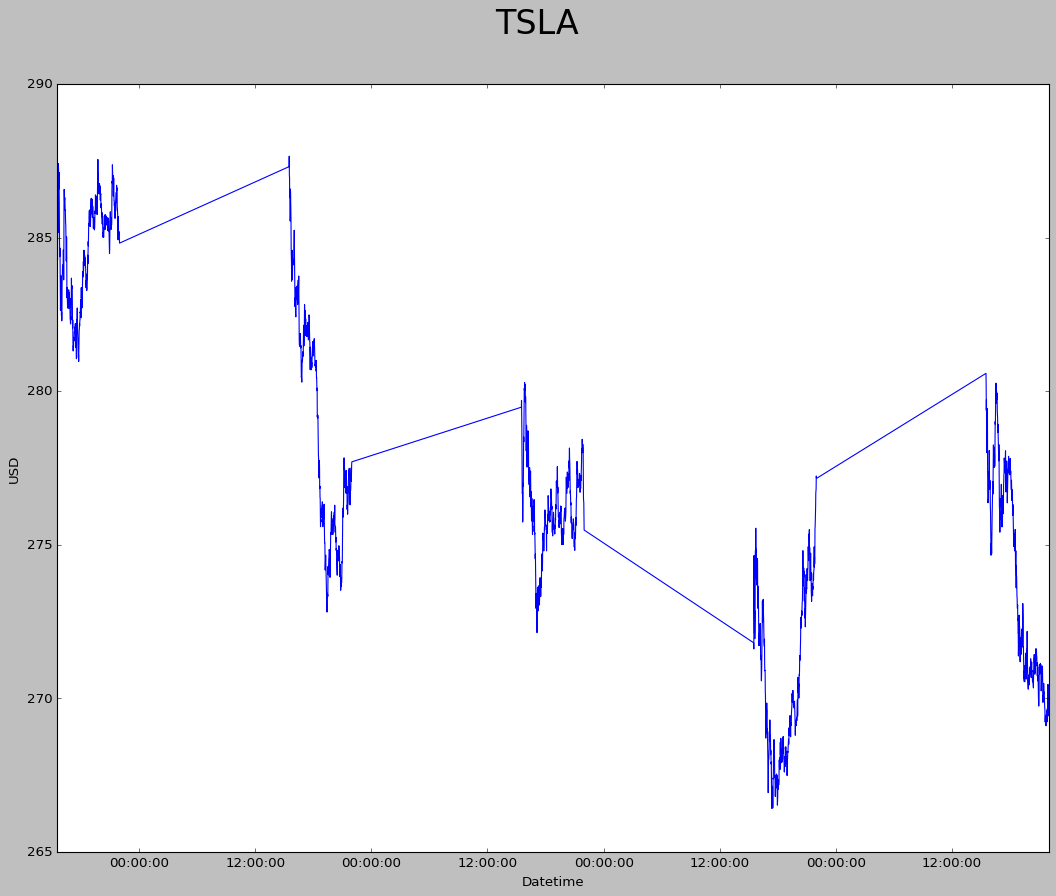

In [66]:
# read in the relevant stock data
palette = sns.color_palette("bright", 6)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,12))
fig.suptitle('TSLA', fontsize=30)
df_stock = pd.read_excel('/Users/Jens/Desktop/Seminar/STOCK_DATA/TSLA.xlsx') # Read excel file
df_stock = df_stock.sort_values(by=['Date']) # Sort the datetime from the beginning to the end
df_stock = df_stock.reset_index(drop=True) # Make a new index:  
df_stock = df_stock[df_stock['Date'].between('2022-08-29 15:30:00', '2022-09-02 22:00:00')] #Extract only the date of interest
df_stock = df_stock.reset_index(drop=True) # Reset the index
df_stock = df_stock.rename(columns={'Date': 'Datetime'}) # change the column name to 'Datetime'
df = pd.DataFrame(df_stock,columns=['Datetime','Last Price'])
sns.lineplot( data=df, x="Datetime", y="Last Price",
        legend="full",palette=palette)
plt.ylabel('USD')
plt.show()      

Datetime      0
Tweet Id      0
Text          0
Username     55
Followers    55
compound      0
dtype: int64
Datetime     0
Tweet Id     0
Text         0
Username     0
Followers    0
compound     0
dtype: int64


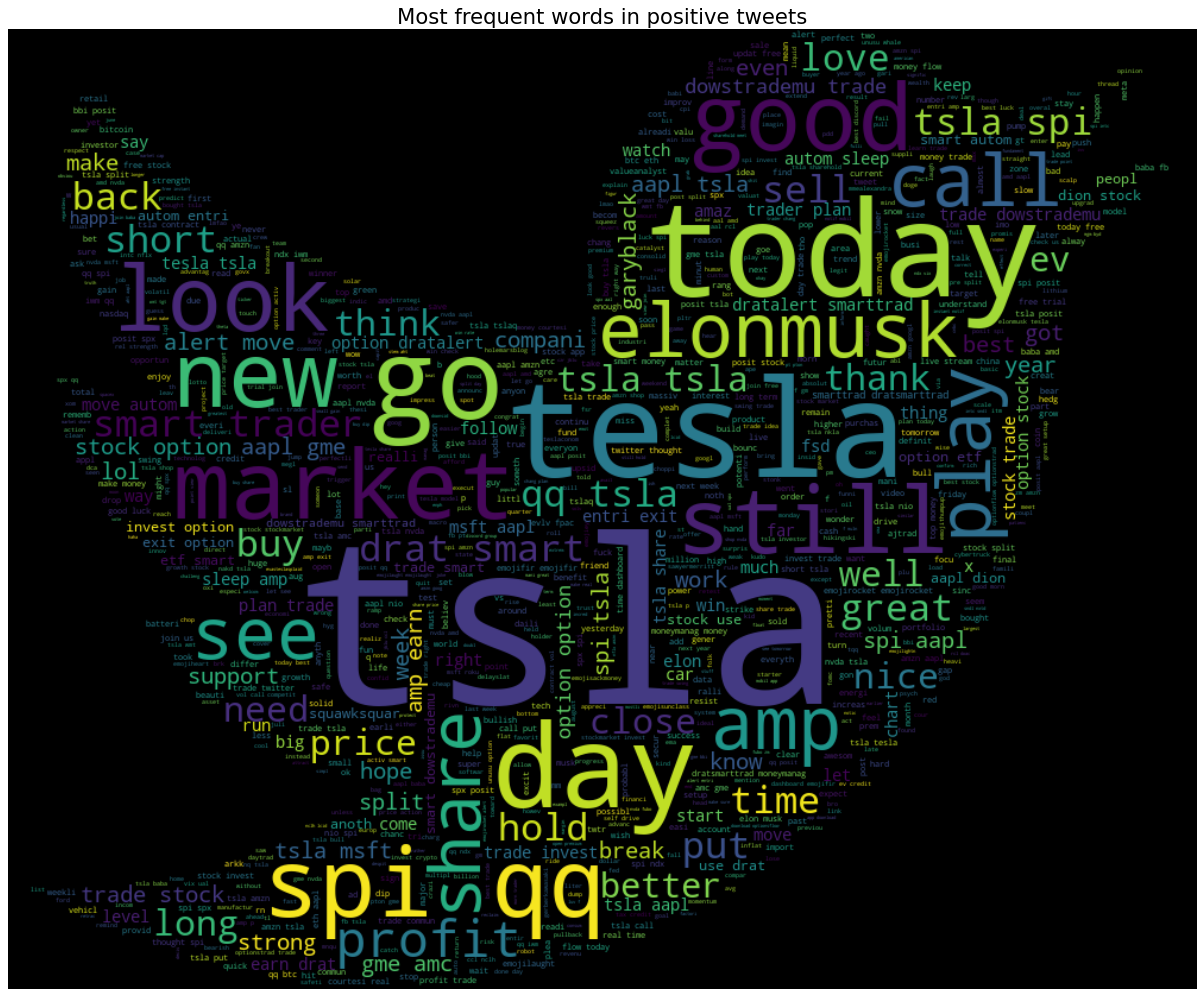

None


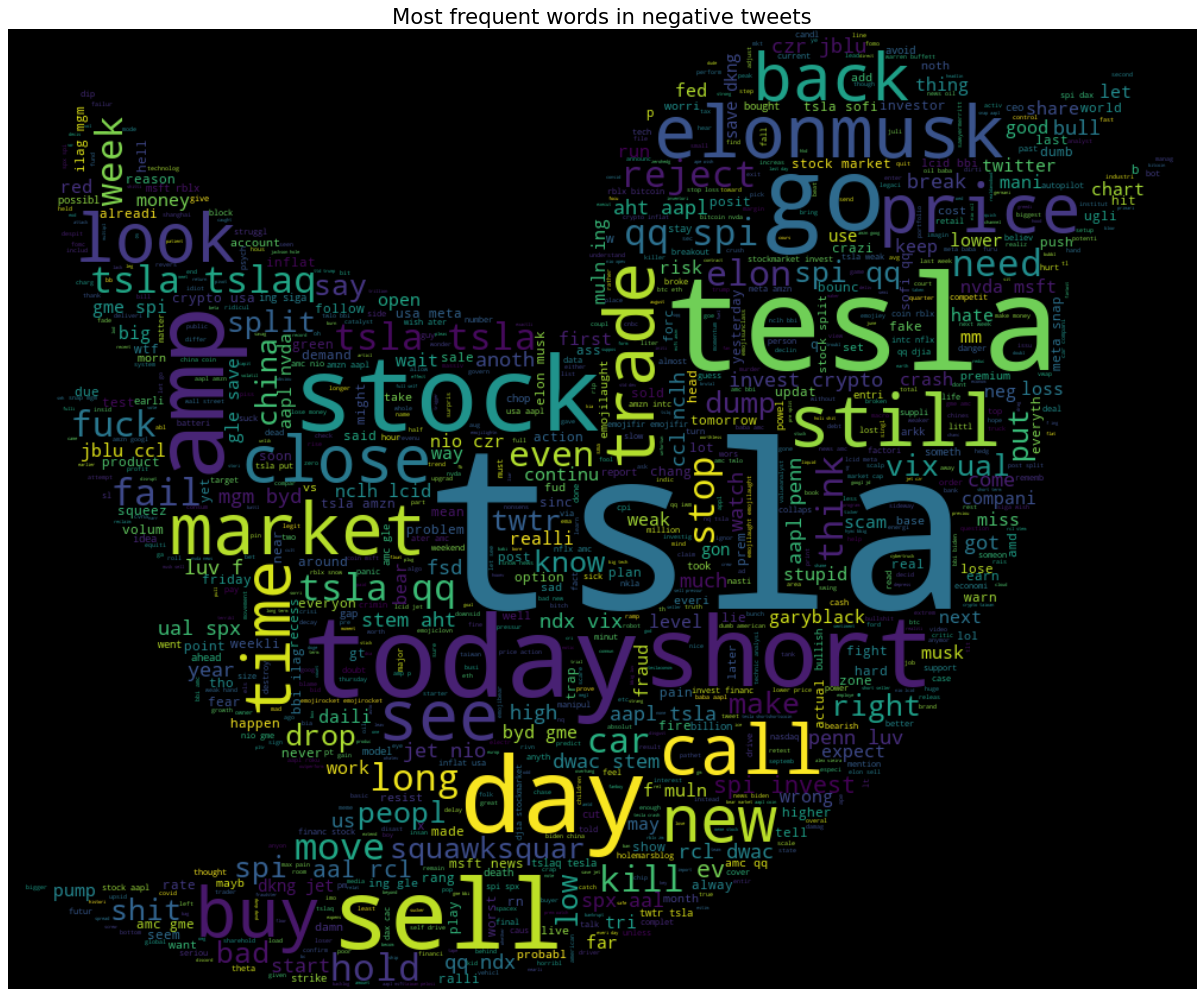

None
Features: 280212

Test accuracy for LinReg: 69.62%
Test accuracy for LogReg: 70.10%
Best model: LogisticRegression
     Return  Followers  Minutes in holdposition  Number of Transactions
0  -16.2454        500                        1                     691
1  -22.5421        500                        2                     691
2  -24.3839        500                        3                     691
3  -27.7953        500                        4                     691
4  -26.9730        500                        5                     691
5  -20.9977       2500                        1                     366
6  -18.0883       2500                        2                     366
7  -15.1129       2500                        3                     366
8  -24.0503       2500                        4                     366
9  -21.8664       2500                        5                     366
10 -17.4806       5000                        1                     273
11 -17.5695     

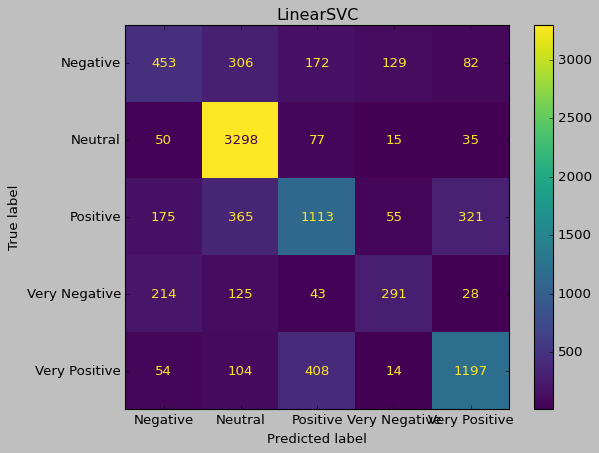

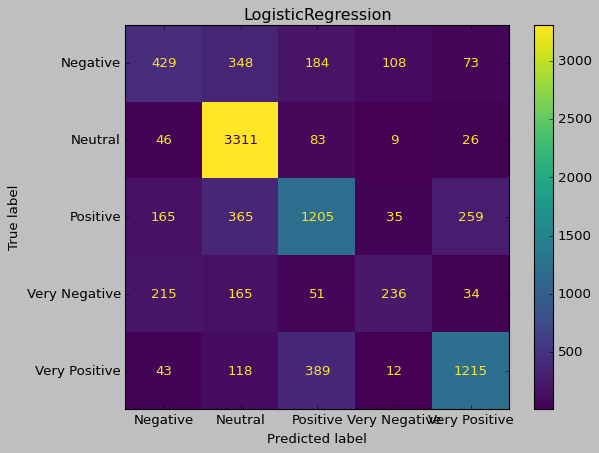

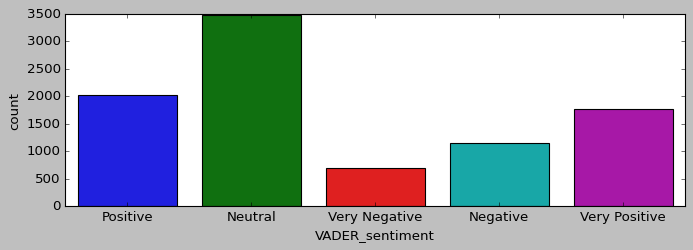

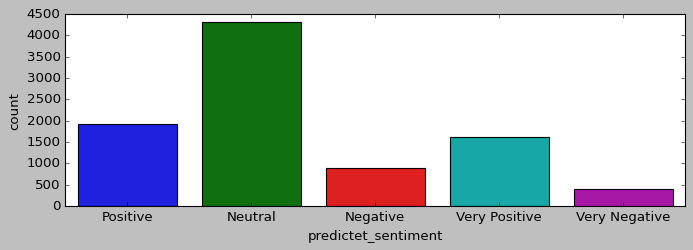

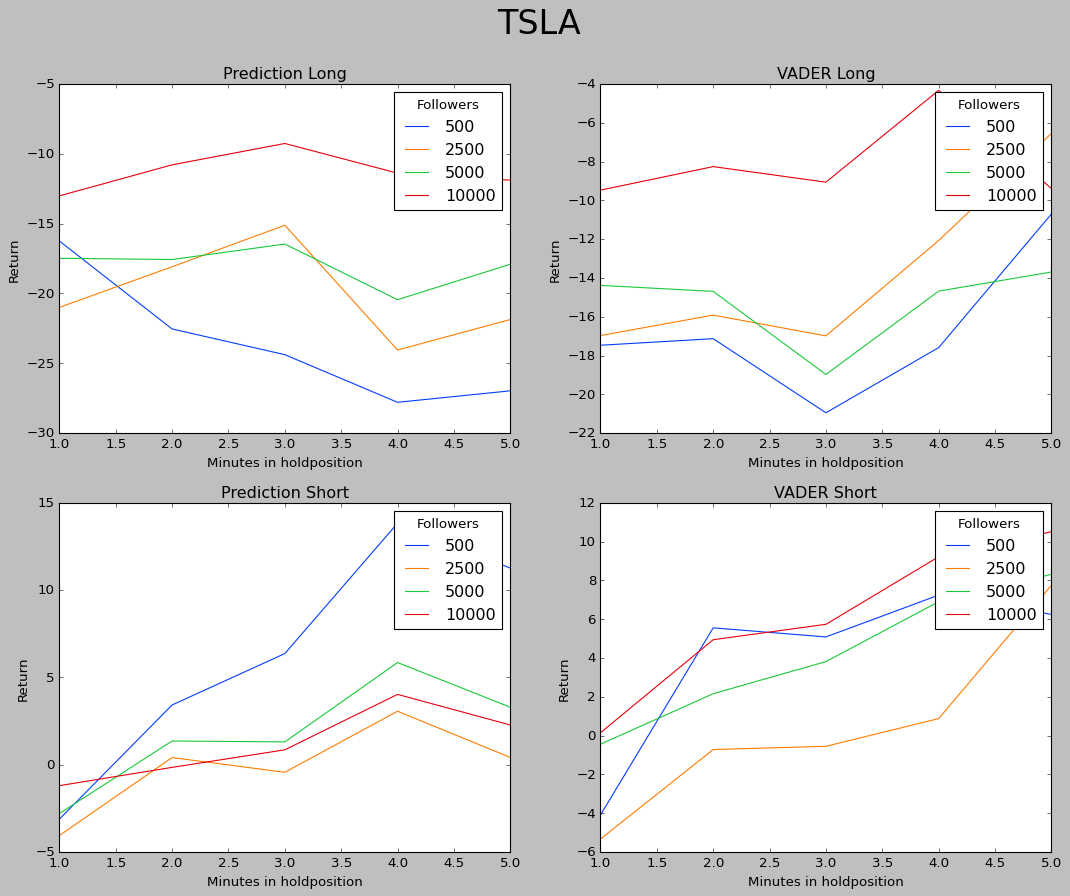

Test accuracy for test_model: 68.25%
   Return  Followers  Minutes in holdposition  Number of Transactions
0 -9.3961    10000.0                      3.0                     105
    Return  Followers  Minutes in holdposition  Number of Transactions
0  19.2304      500.0                      4.0                     166
    Return  Followers  Minutes in holdposition  Number of Transactions
0 -20.0528    10000.0                      4.0                     123
   Return  Followers  Minutes in holdposition  Number of Transactions
0  6.4699    10000.0                      5.0                      43
Best pred return for long: -9.40
Best pred return for short: 19.23
Best VADER return for long: -20.05
Best VADER return for short: 6.47
TOTAL for pred: 9.83
TOTAL for Vader: -13.58


In [47]:
total_TSLA, best_parameters_TSLA = function('/Users/Jens/Desktop/Seminar/TSLA_open.csv','TSLA','/Users/Jens/Desktop/Seminar/STOCK_DATA/TSLA.xlsx')

### NIO

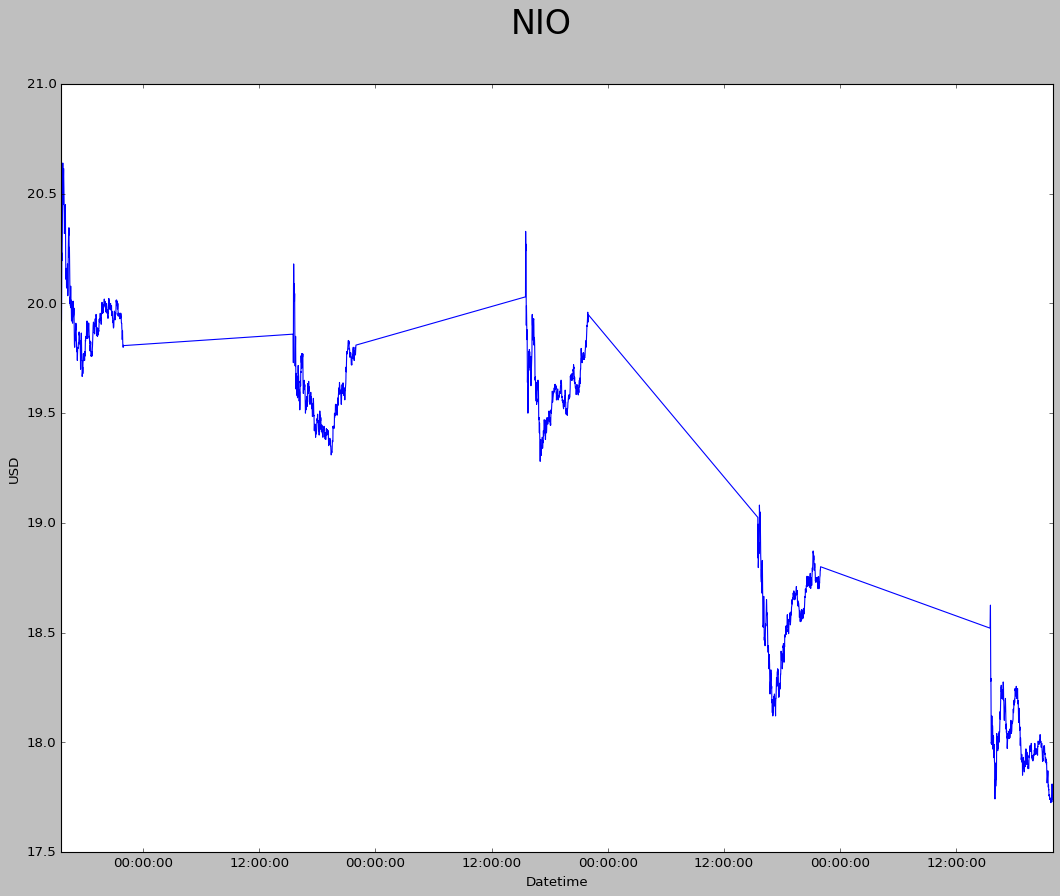

In [67]:
# read in the relevant stock data
palette = sns.color_palette("bright", 6)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,12))
fig.suptitle('NIO', fontsize=30)
df_stock = pd.read_excel('/Users/Jens/Desktop/Seminar/STOCK_DATA/NIO.xlsx') # Read excel file
df_stock = df_stock.sort_values(by=['Date']) # Sort the datetime from the beginning to the end
df_stock = df_stock.reset_index(drop=True) # Make a new index:  
df_stock = df_stock[df_stock['Date'].between('2022-08-29 15:30:00', '2022-09-02 22:00:00')] #Extract only the date of interest
df_stock = df_stock.reset_index(drop=True) # Reset the index
df_stock = df_stock.rename(columns={'Date': 'Datetime'}) # change the column name to 'Datetime'
df = pd.DataFrame(df_stock,columns=['Datetime','Last Price'])
sns.lineplot( data=df, x="Datetime", y="Last Price",
        legend="full",palette=palette)
plt.ylabel('USD')
plt.show()      

Datetime     0
Tweet Id     0
Text         0
Username     8
Followers    8
compound     0
dtype: int64
Datetime     0
Tweet Id     0
Text         0
Username     0
Followers    0
compound     0
dtype: int64


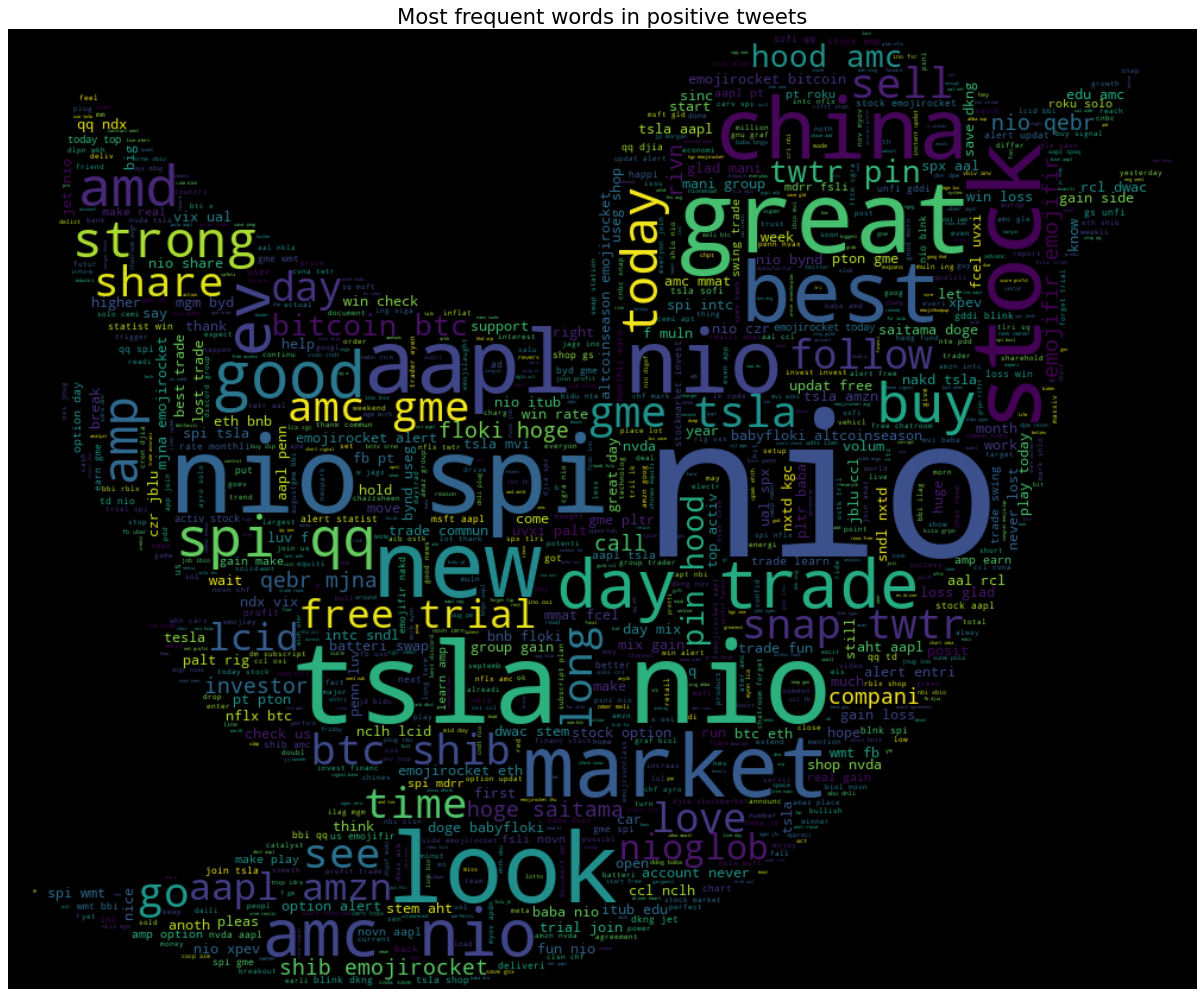

None


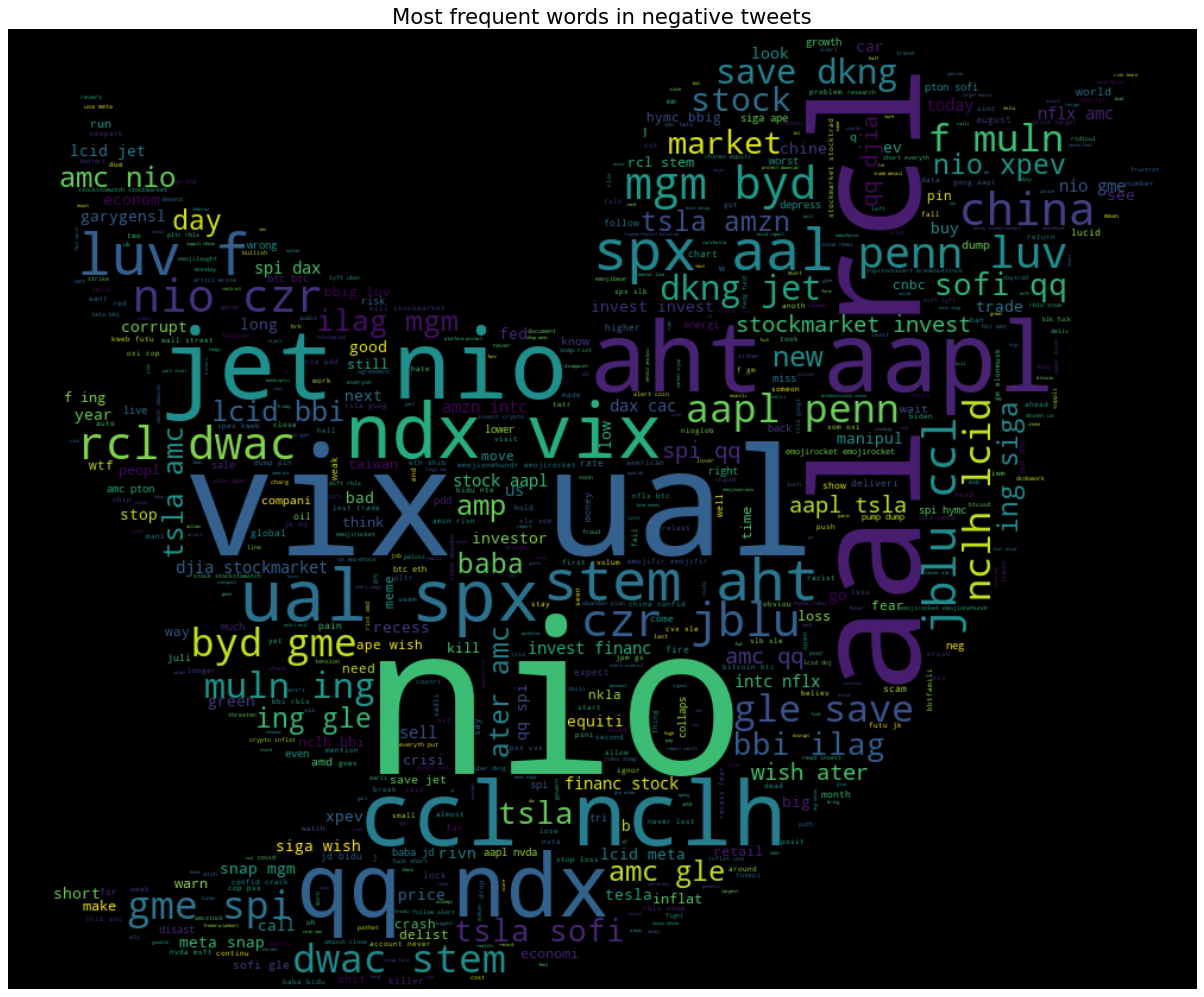

None
Features: 49029

Test accuracy for LinReg: 67.00%
Test accuracy for LogReg: 65.50%
Best model: LinearSVC
    Return  Followers  Minutes in holdposition  Number of Transactions
0   0.3511        500                        1                      75
1   0.4946        500                        2                      75
2   0.5399        500                        3                      75
3   0.8513        500                        4                      75
4   0.6959        500                        5                      75
5   0.1441       2500                        1                      41
6   0.2101       2500                        2                      41
7   0.1829       2500                        3                      41
8   0.4861       2500                        4                      41
9   0.3322       2500                        5                      41
10  0.0543       5000                        1                      25
11  0.0378       5000                 

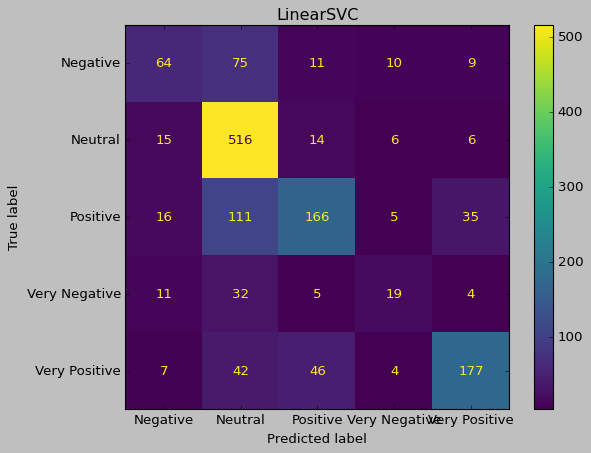

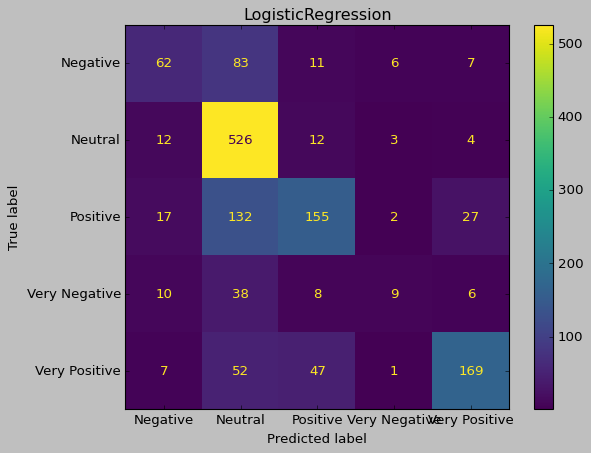

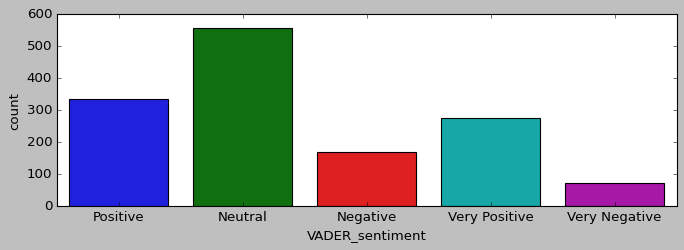

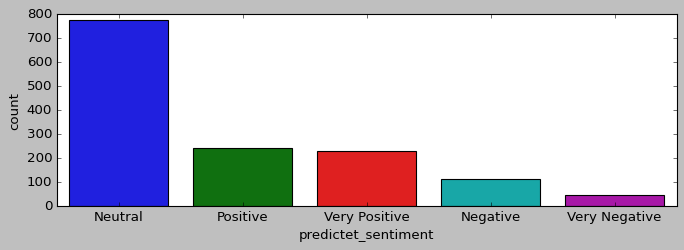

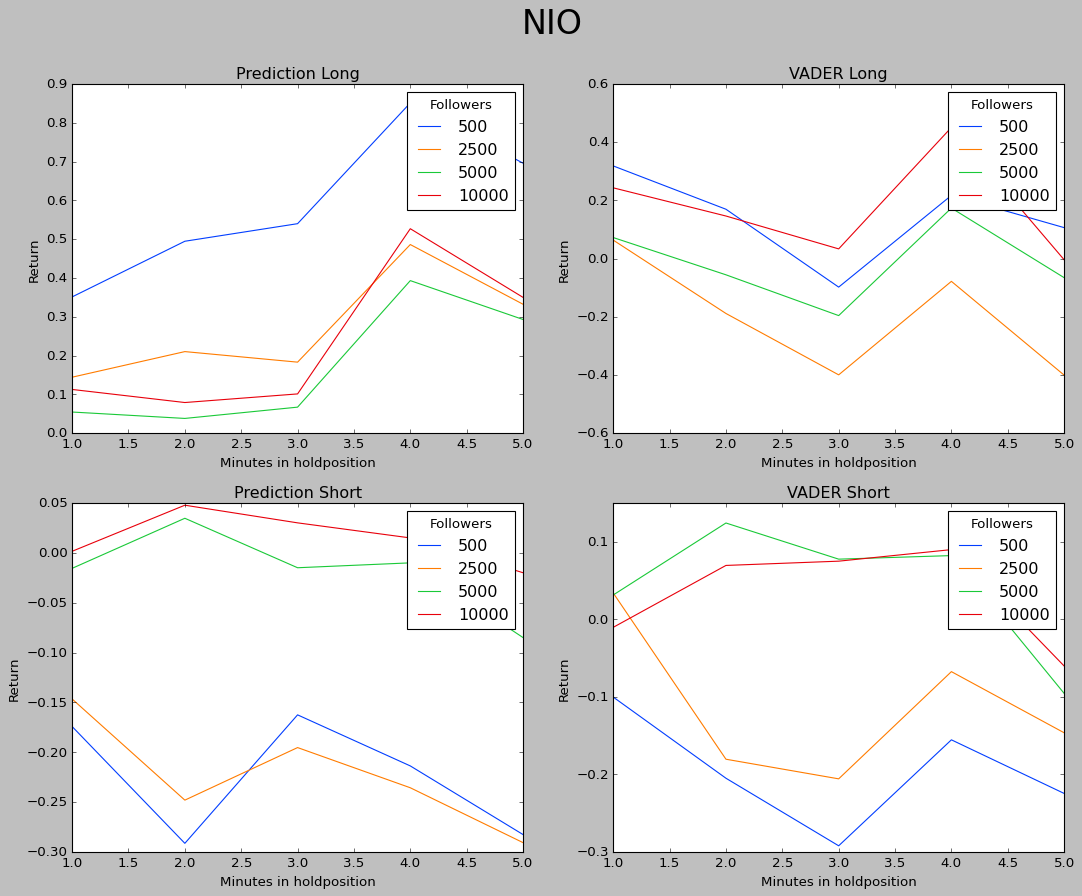

Test accuracy for test_model: 59.53%
   Return  Followers  Minutes in holdposition  Number of Transactions
0 -0.6329      500.0                      4.0                      69
   Return  Followers  Minutes in holdposition  Number of Transactions
0     0.0    10000.0                      2.0                       0
   Return  Followers  Minutes in holdposition  Number of Transactions
0  0.0644    10000.0                      4.0                      18
   Return  Followers  Minutes in holdposition  Number of Transactions
0  0.2203     5000.0                      2.0                      13
Best pred return for long: -0.63
Best pred return for short: 0.00
Best VADER return for long: 0.06
Best VADER return for short: 0.22
TOTAL for pred: -0.63
TOTAL for Vader: 0.28


In [48]:
total_NIO, best_parameters_NIO = function('/Users/Jens/Desktop/Seminar/NIO_open.csv','NIO','/Users/Jens/Desktop/Seminar/STOCK_DATA/NIO.xlsx')

### AMZN

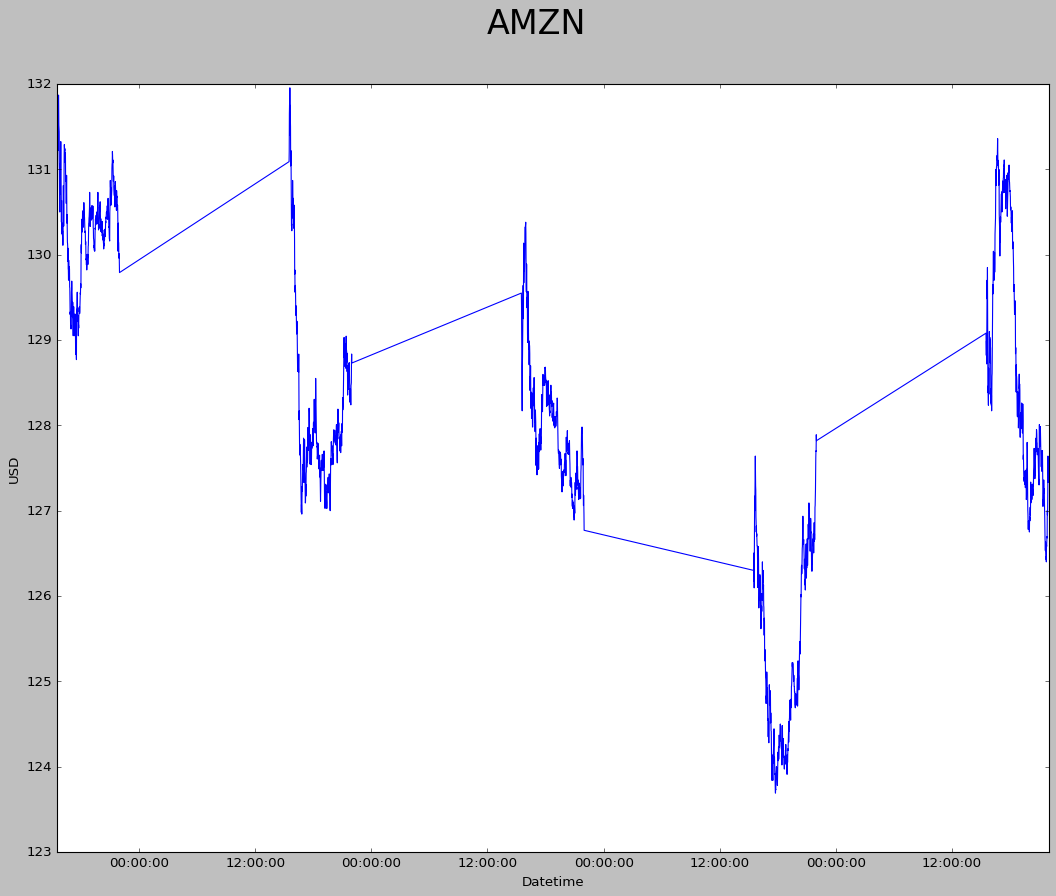

In [68]:
# read in the relevant stock data
palette = sns.color_palette("bright", 6)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,12))
fig.suptitle('AMZN', fontsize=30)
df_stock = pd.read_excel('/Users/Jens/Desktop/Seminar/STOCK_DATA/AMZN.xlsx') # Read excel file
df_stock = df_stock.sort_values(by=['Date']) # Sort the datetime from the beginning to the end
df_stock = df_stock.reset_index(drop=True) # Make a new index:  
df_stock = df_stock[df_stock['Date'].between('2022-08-29 15:30:00', '2022-09-02 22:00:00')] #Extract only the date of interest
df_stock = df_stock.reset_index(drop=True) # Reset the index
df_stock = df_stock.rename(columns={'Date': 'Datetime'}) # change the column name to 'Datetime'
df = pd.DataFrame(df_stock,columns=['Datetime','Last Price'])
sns.lineplot( data=df, x="Datetime", y="Last Price",
        legend="full",palette=palette)
plt.ylabel('USD')
plt.show()      

Datetime      0
Tweet Id      8
Text          8
Username     23
Followers    23
compound      0
dtype: int64
Datetime     0
Tweet Id     0
Text         0
Username     0
Followers    0
compound     0
dtype: int64


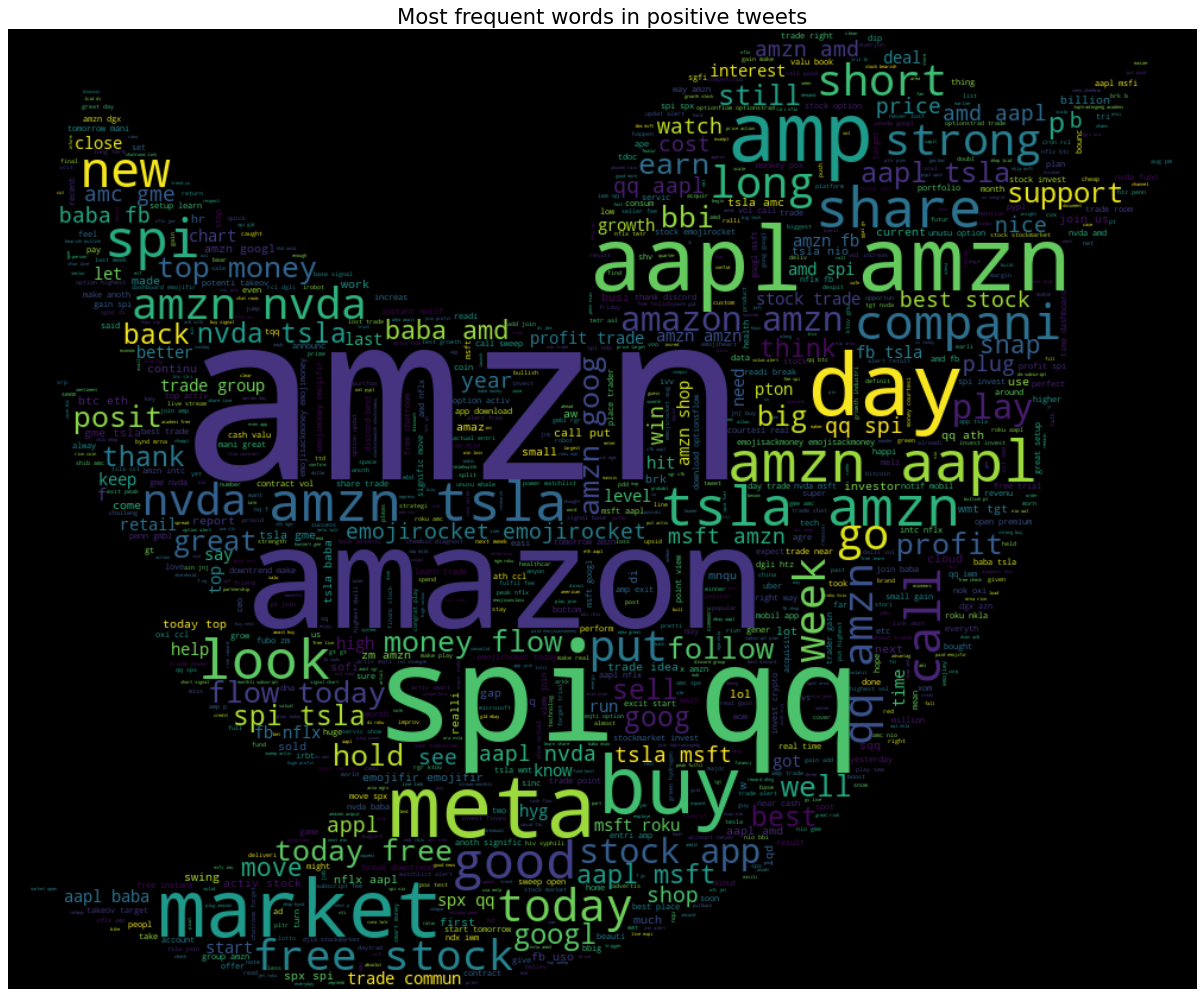

None


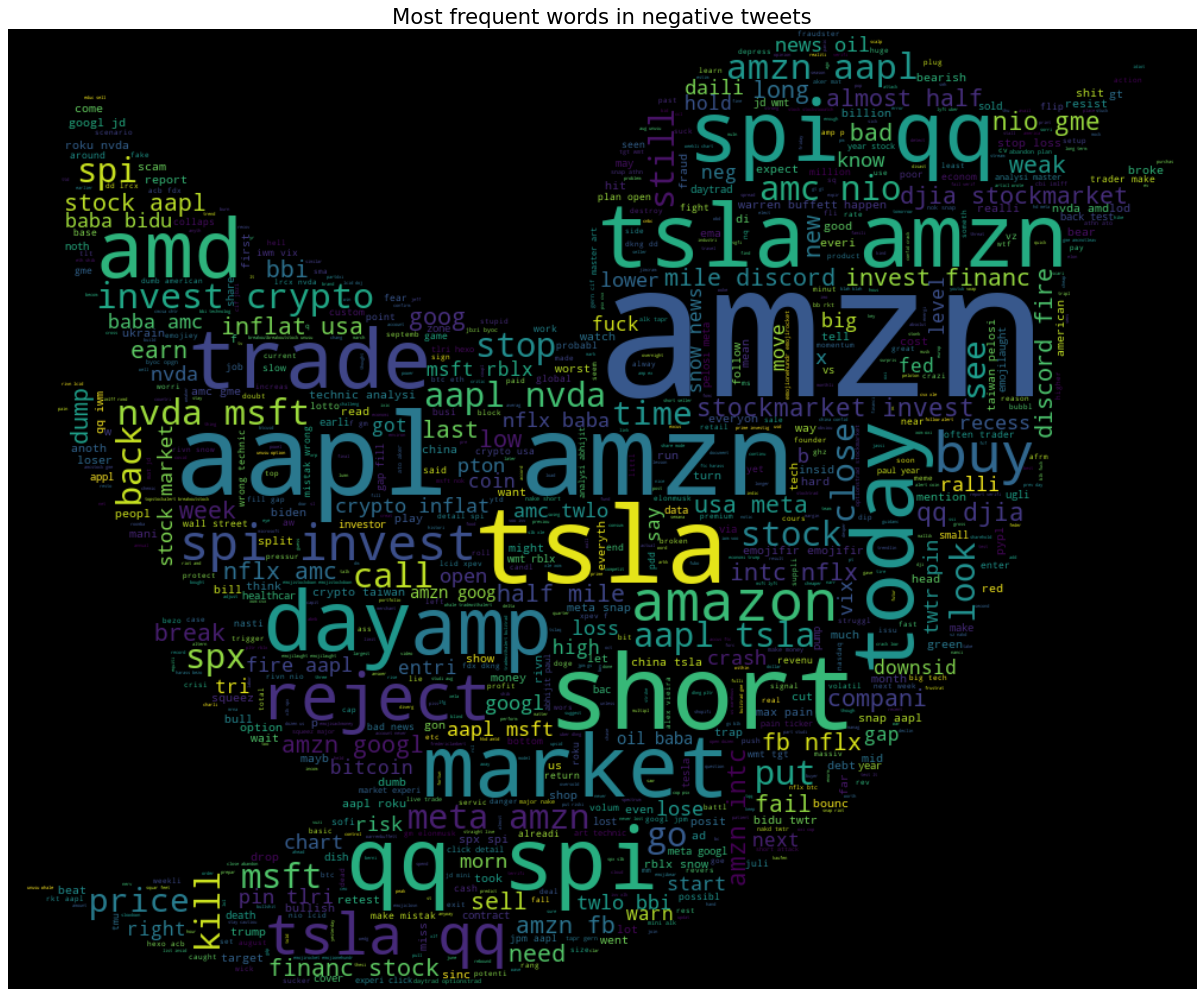

None
Features: 98358

Test accuracy for LinReg: 67.62%
Test accuracy for LogReg: 67.10%
Best model: LinearSVC
    Return  Followers  Minutes in holdposition  Number of Transactions
0  -0.1845        500                        1                     197
1   1.2900        500                        2                     197
2   2.0585        500                        3                     197
3   1.3445        500                        4                     197
4   0.7982        500                        5                     197
5   0.5704       2500                        1                     122
6   1.8448       2500                        2                     122
7   3.4777       2500                        3                     122
8   2.8496       2500                        4                     122
9   0.9730       2500                        5                     122
10  1.0652       5000                        1                      94
11  2.8841       5000                 

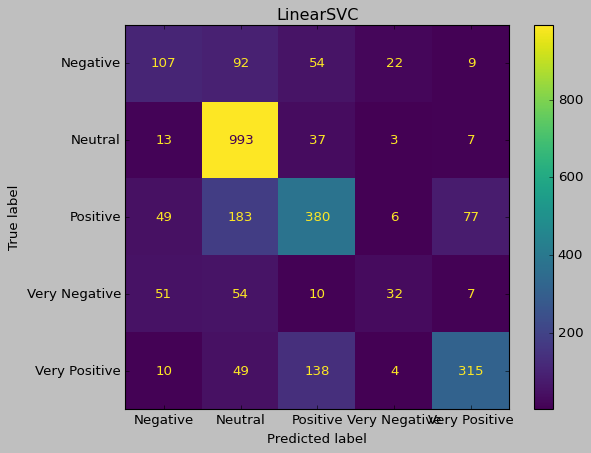

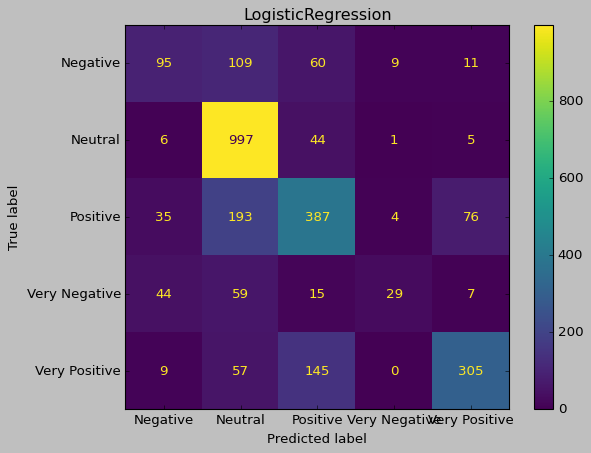

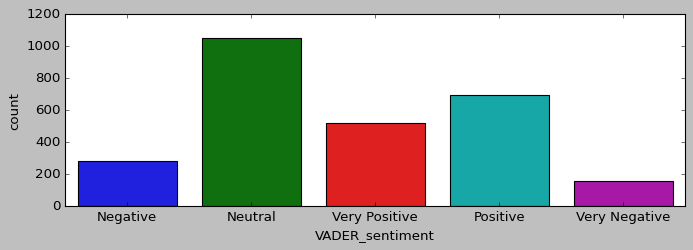

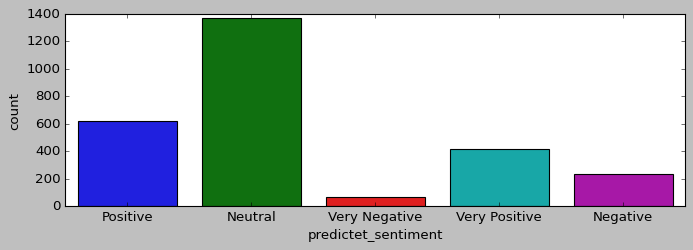

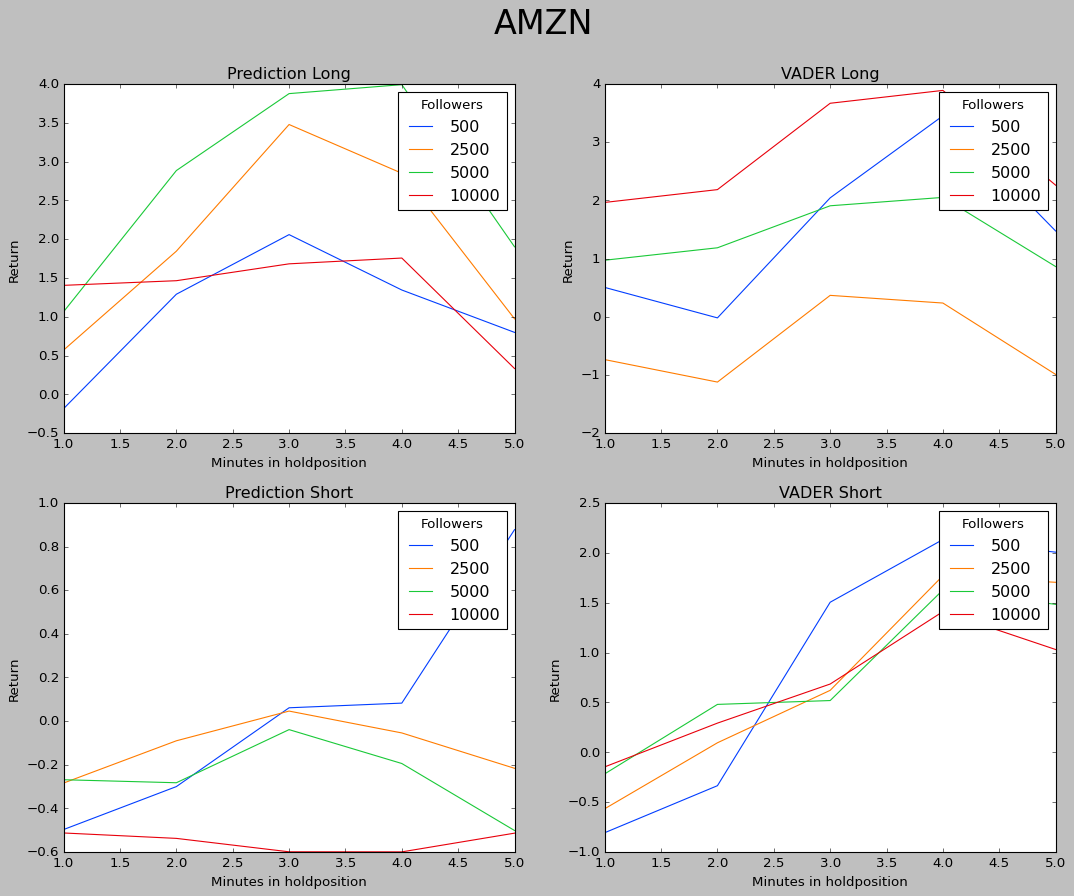

Test accuracy for test_model: 68.40%
   Return  Followers  Minutes in holdposition  Number of Transactions
0  1.2123     5000.0                      4.0                      61
   Return  Followers  Minutes in holdposition  Number of Transactions
0  1.8821      500.0                      5.0                      27
   Return  Followers  Minutes in holdposition  Number of Transactions
0  1.0918    10000.0                      4.0                      40
   Return  Followers  Minutes in holdposition  Number of Transactions
0   3.809      500.0                      4.0                      58
Best pred return for long: 1.21
Best pred return for short: 1.88
Best VADER return for long: 1.09
Best VADER return for short: 3.81
TOTAL for pred: 3.09
TOTAL for Vader: 4.90


In [49]:
total_AMZN, best_parameters_AMZN = function('/Users/Jens/Desktop/Seminar/AMZN_open.csv','AMZN','/Users/Jens/Desktop/Seminar/STOCK_DATA/AMZN.xlsx')